## Прогнозирование стоимости автомобиля по характеристикам
В Москве есть компании, которая занимается продажей автомобилей с пробегом. 

Основная задача компании и её менеджеров — максимально быстро находить выгодные предложения (проще говоря, купить ниже рынка, а продать дороже рынка). 

Руководство компании просит вашу команду создать модель, которая будет предсказывать стоимость автомобиля по его характеристикам.

Если такая модель будет работать хорошо, то вы сможете быстро выявлять выгодные предложения (когда желаемая цена продавца ниже предсказанной рыночной цены). Это значительно ускорит работу менеджеров и повысит прибыль компании.

Есть проблема: исторически сложилось, что компания изначально не собирала данные. Есть только небольшой датасет с историей продаж за короткий период, которого для обучения модели будет явно мало. Его мы будем использовать для теста, остальное придется собрать самим.

## Импорт библиотек

In [1]:
import numpy as np   # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import scipy 
from collections import Counter

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor 
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from scipy.special import boxcox1p

from wordcloud import WordCloud
import string
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib.patches as mpatches
from matplotlib import style
style.use('fivethirtyeight')
from matplotlib import rcParams
rcParams['figure.figsize'] = 15, 10

import warnings
warnings.filterwarnings('ignore')

In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.19.2


In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
CURRENT_DATE = pd.to_datetime('12/10/2021')

## Setup

In [162]:
VERSION    = 16
DIR_TRAIN  = '../input/parsing-all-moscow-auto-ru-09-09-2020/' # подключил к ноутбуку внешний датасет
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   # 20%

# CATBOOST
ITERATIONS = 5000
LR         = 0.1

In [6]:
# Установим параметры для изображений:
sns.set_context(
    "notebook", 
    font_scale=1.5,       
    rc={ 
        "figure.figsize": (15, 10), 
        "axes.titlesize": 18 
    }
)


## Data

In [8]:
train = pd.read_csv('train_12_10_2021_auto_ru.csv') # датасет для обучения модели
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [9]:
pd.set_option('display.max_columns', None)   # для отображения всех столбцов

## Функции для использование в проекте

In [10]:
def mape(y_true, y_pred):
    '''
    Функция определяет средний абсолютный процент ошибки или 
    среднюю относительную ошибку прогноза (Mean Absolute Percentage Error, MAPE)
    
    '''
    
    return np.mean(np.abs((y_pred-y_true)/y_true))


In [11]:
def informative(data):
    '''
    Функция проверяет признаки датасета на неинформативность.
    В случае, если в признаке более 95% строк содержат одно и то же значение,
    выводится имя признака, доля одинаковых значений и общее их число.
    
    '''
    
    num_rows = len(data.index)
    low_information_cols = []   

    for col in data.columns:
        cnts = data[col].value_counts(dropna=False)
        top_pct = (cnts/num_rows).iloc[0]
        if top_pct > 0.95:
            low_information_cols.append(col)
            print('{0}: {1:.5f}%'.format(col, top_pct*100))
            print(cnts)
            print()

    if len(low_information_cols) == 0:
        print("Представленный датасет не имеет признаков низкой информативности.")
            

In [12]:
def nominal_features(column_name, data, rotate=90, x_shift_mult=0, percentage=True):
    '''
    Функция рисует распределение категориальных признаков 
    и отображает их процентное содержание
   
    '''
    
    ax = sns.countplot(x=column_name,
                       data=data,
                       order=data[column_name].value_counts().index, orient="h")
    if percentage:
        total = len(data[column_name])
        for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height()/total)
            x = p.get_x() + x_shift_mult*p.get_width()
            y = p.get_y() + p.get_height()+8
            ax.annotate(percentage, (x, y))
    plt.xticks(rotation=rotate)


In [13]:
def numeric_features(df, df_col, bins=100):
    '''
    Функция выводит описательные статистики числового признака, 
    а также рисует его боксплот и распределение.
    
    На вход необходимо подать датасет и признак для анализа.
    
    '''
    
    print(df[df_col].describe()[["min", "max", "25%", "50%", "75%", "std"]])
    
    fig, axes = plt.subplots(2, 1, figsize=(15, 15))
        
    # boxplot    
    df.boxplot(column=df_col, vert=False, ax=axes[0])
    
    # distplot
    sns.distplot(df[df_col], bins=bins, ax=axes[1])


In [14]:
def get_differences(df_col):
    '''
    Выводит на печать отличия в признаках тренировочной и тестовой
    выборок, возвращает индексы отличающихся элементов
    
    df_col - название столбца датасета
    
    '''
    
    dif_1vs2 = list(set(list(train[df_col].value_counts().index)) -
                 set(list(test[df_col].value_counts().index)))
    
    print()
    print("=================================")
    print("Train - Test differences in {} \n".format(df_col))
    print(train[df_col].value_counts()[dif_1vs2]) if len(dif_1vs2) != 0 else print("No differences")
    
    dif_2vs1 = list(set(list(test[df_col].value_counts().index)) -
                 set(list(train[df_col].value_counts().index)))
   
    print()
    print("=================================")
    print("Test - Train differences in {} \n".format(df_col))
    print(test[df_col].value_counts()[dif_2vs1]) if len(dif_2vs1) != 0 else print("No differences")
    
    return dif_1vs2, dif_2vs1


In [15]:
def outliers(df, df_col):
    '''
    Определение наличия выбросов в отдельном признаке датасета.
    Расчёт данных описательной статистики. Определение границ выбросов.
    Подсчёт общего количества выбросов в признаке.
    
    df_col - название столбца датасета. 
    
    '''
    
    q1 = df[df_col].quantile(0.25)
    q3 = df[df_col].quantile(0.75)
    IQR = q3 - q1
    low = q1 - (1.5 * IQR)
    high = q3 + (1.5 * IQR)
    for i in df[df_col]:
        if (i <= low) or (i >= high):
            print("В признаке '{}' есть значения, которые могут считаться выбросами".format(df_col))
            break
        
    print("Количество выбросов в признаке '{}': {}."
          .format(df_col, ((df[df_col] < (q1 - 1.5 * IQR)) | (df[df_col] > (q3 + 1.5 * IQR))).sum()))
    print("Границы выбросов: [{}, {}], IQR: {}".format(low, high, IQR))
    

In [16]:
def split(df):
    '''
    Функция для разбиения датасета на тренировочный и валидационный
    
    '''
    
    train_df = df.query('sample == 1').drop(['sample'], axis=1)
    
    y = train_df.price.values            
    X = train_df.drop(columns=['price'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)
    
    return X_train, X_test, y_train, y_test


# EDA для тестового датасета по всем признакам

In [17]:
test.head(3)

bodyType  brand                                            car_url   color  \
0  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   синий   
1  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...  чёрный   
2  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/superb/11...   серый   

                                  complectation_dict  \
0                                                NaN   
1                                                NaN   
2  {"id":"20026336","name":"Ambition","available_...   

                                         description engineDisplacement  \
0  Все автомобили, представленные в продаже, прох...            1.2 LTR   
1  ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...            1.6 LTR   
2  Все автомобили, представленные в продаже, прох...            1.8 LTR   

  enginePower                                     equipment_dict fuelType  \
0     105 N12  {"engine-proof":true,"tinted-glass":true,"airb...   бензин   
1     110 N12  {"cruise-control":true,"asr":true,"esp":true,"...   бензин   
2     152 N12  {"cruise-control":true,"tinted-glass":true,"es...   бензин   

                                               image  mileage  modelDate  \
0  https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...    74000       2013   
1  https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...    60563       2017   
2  https://avatars.mds.yandex.net/get-autoru-vos/...    88000       2013   

                                          model_info model_name  \
0  {"code":"OCTAVIA","name":"Octavia","ru_name":"...    OCTAVIA   
1  {"code":"OCTAVIA","name":"Octavia","ru_name":"...    OCTAVIA   
2  {"code":"SUPERB","name":"Superb","ru_name":"Су...     SUPERB   

                     name  numberOfDoors  parsing_unixtime priceCurrency  \
0      1.2 AMT (105 л.с.)              5        1603226273           RUB   
1       1.6 MT (110 л.с.)              5        1603226277           RUB   
2  DSG 1.8 AMT (152 л.с.)              5        1603226280           RUB   

   productionDate     sell_id  \
0            2014  1100575026   
1            2017  1100549428   
2            2014  1100658222   

                                           super_gen     vehicleConfiguration  \
0  {"id":"10373605","displacement":1197,"engine_t...       LIFTBACK ROBOT 1.2   
1  {"id":"20913311","displacement":1598,"engine_t...  LIFTBACK MECHANICAL 1.6   
2  {"id":"20026323","nameplate":"DSG","displaceme...       LIFTBACK ROBOT 1.8   

  vehicleTransmission    vendor    Владельцы Владение       ПТС    Привод  \
0    роботизированная  EUROPEAN  3 или более      NaN  Оригинал  передний   
1        механическая  EUROPEAN   1 владелец      NaN  Оригинал  передний   
2    роботизированная  EUROPEAN   1 владелец      NaN  Оригинал  передний   

    Руль           Состояние     Таможня  
0  Левый  Не требует ремонта  Растаможен  
1  Левый  Не требует ремонта  Растаможен  
2  Левый  Не требует ремонта  Растаможен

In [18]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [19]:
# проверка признаков датасета на неинформативность
informative(test)

priceCurrency: 100.00000%
RUB    34686
Name: priceCurrency, dtype: int64

Руль: 95.96667%
Левый     33287
Правый     1399
Name: Руль, dtype: int64

Состояние: 100.00000%
Не требует ремонта    34686
Name: Состояние, dtype: int64

Таможня: 100.00000%
Растаможен    34686
Name: Таможня, dtype: int64



В тестовом датасете 3 признака (priceCurrency, Состояние, Таможня) не обладают информативностью. 

Если в датасете, для обучения будет схожая картина, то эти признаки нужно будет удалить перед обучением модели.

In [20]:
# как представлена информация по каждому id
for idx, row in test[255:256].iterrows():
    print(idx, row)

255 bodyType                                                внедорожник 5 дв.
brand                                                               SKODA
car_url                 https://auto.ru/cars/used/sale/skoda/kodiaq/11...
color                                                               белый
complectation_dict                                                    NaN
description             Комфорт: 5. Безопасность: 5. Обзор: 2. Мультим...
engineDisplacement                                                2.0 LTR
enginePower                                                       150 N12
equipment_dict          {"cruise-control":true,"airbag-driver":true,"r...
fuelType                                                           дизель
image                   https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...
mileage                                                             41444
modelDate                                                            2016
model_info              {"code":"K

In [21]:
print('Кол-во признаков в тестовом датасете:', test.shape[1])
categorical_features_indices = np.where(test.dtypes != np.int64)[0]
print('Кол-во категориальных признаков в тестовом датасете:', len(categorical_features_indices))

Кол-во признаков в тестовом датасете: 32
Кол-во категориальных признаков в тестовом датасете: 26


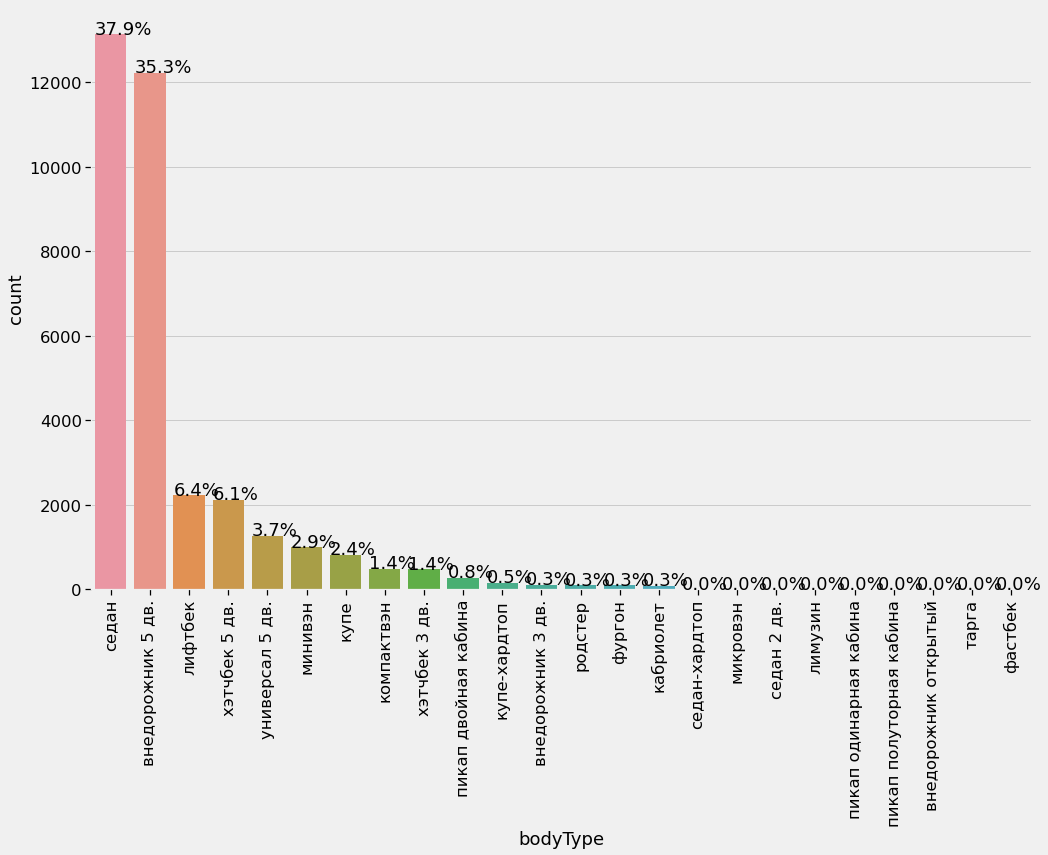

In [22]:
nominal_features("bodyType", test, rotate=90)

In [23]:
print('В датасете представлены {} типа кузовов автомобилей\n'.format(len(test.bodyType.unique())))
# test.bodyType.value_counts(normalize=True)

В датасете представлены 24 типа кузовов автомобилей



В датасете представлено большое количество разнообразных типов кузова. 
Распределение логнормальное, имеет тяжёлый правый хвост и требует оптимизации. 
Рабочая версия состоит в сокращении общего количества путём замены редко встречающихся типов кузова на тип "другой".
Критерий отбора: частота появления более 1 % в датасете.

In [24]:
# какие бренды представлены в датасете
d = test.brand.unique()
print('Датасет представлен автомобилями {} марок:\n{}'.format(len(d), sorted(d)))

Датасет представлен автомобилями 12 марок:
['AUDI', 'BMW', 'HONDA', 'INFINITI', 'LEXUS', 'MERCEDES', 'MITSUBISHI', 'NISSAN', 'SKODA', 'TOYOTA', 'VOLKSWAGEN', 'VOLVO']


Информация необходима для парсинга данных для подготовки тренировочной выборки.    
Информация по другим брендам будет избыточна для нас и нет необходимости в её сборе.

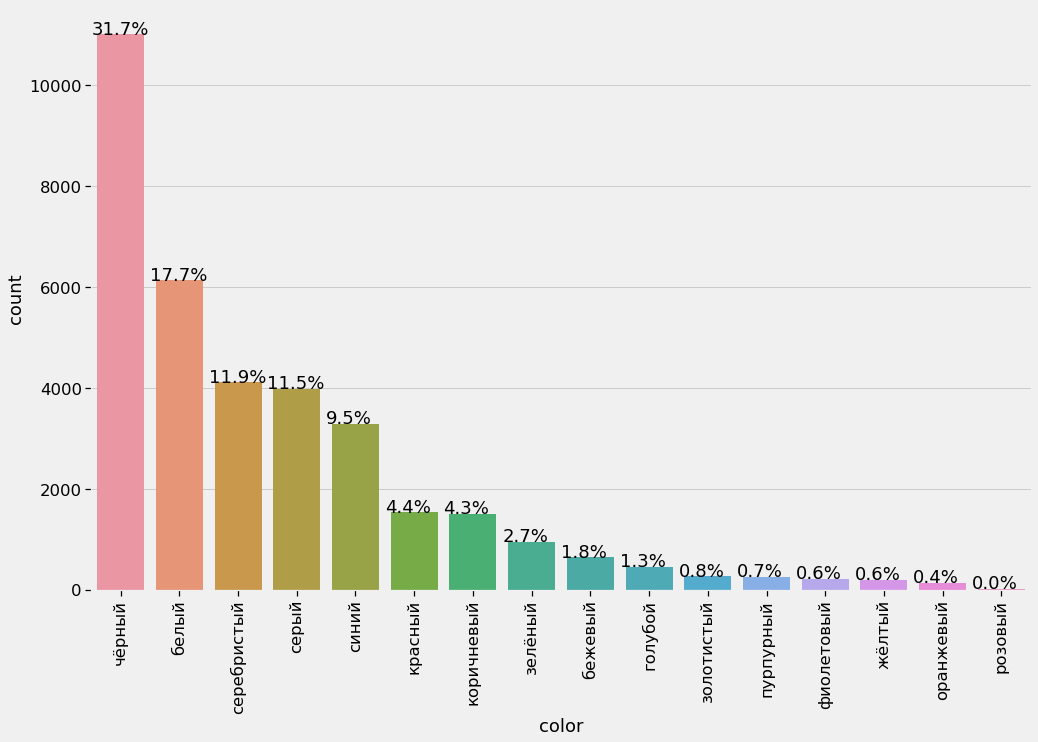

In [25]:
nominal_features("color", test, rotate=90, x_shift_mult=-1/8)

In [26]:
print('В датасете представлены автомобили {} цветов\n'.format(len(test.color.unique())))
# test.color.value_counts(normalize=True)

В датасете представлены автомобили 16 цветов



В датасете представлено большое разнообразие расцветок кузова автомобилей. Распределение логнормальное, имеет тяжёлый правый хвост и требует оптимизации. Рабочая версия состоит в сокращении общего количества путём замены редко встречающихся расцветок на тип "другой". Критерий отбора: частота появления более 1.5 % в датасете.

In [27]:
test.complectation_dict[2]

'{"id":"20026336","name":"Ambition","available_options":["heated-wash-system","airbag-passenger","lock","door-sill-panel","electro-mirrors","mirrors-heat","cooling-box","computer","seat-transformation","wheel-power","fabric-seats","airbag-side","abs","wheel-leather","climate-control-1","esp","adaptive-light","audiopreparation","ashtray-and-cigarette-lighter","front-centre-armrest","electro-window-back","16-inch-wheels","body-mouldings","condition","airbag-driver","isofix","aux","electro-window-front","light-sensor","hcc","ptf","rain-sensor","tyre-pressure","audiosystem-cd","front-seats-heat","wheel-configuration2","wheel-configuration1","immo","12v-socket","third-rear-headrest"]}'

In [28]:
test.description[2]

'Все автомобили, представленные в продаже, проходят тщательную проверку по более 40 параметрам. Предоставляем гарантию юридической чистоты, а так же год технической гарантии на двигатель и КПП. Бесплатный тест-драйв. Возможно оформление автомобиля в кредит!\n\nПреимущества автокредитования:\n— Первоначальный взнос от 0%;\n— Более 30 кредитных программ;\n— Процентная ставка от 6% годовых;\n— Срок кредита от 6 месяцев до 7 лет;\n— Оформление кредита по двум документам;\n— Досрочное погашение без штрафов и комиссий;\n— Сумма кредита до 2 млн рублей;\n— Оформление КАСКО – по желанию;\n— Без справок и поручителей.\n\nСотрудничаем с 12 аккредитованными и сертифицированными банками РФ, среднее время ожидания решения банка 20–30 минут.\n\nПри покупке автомобиля по программе «Trade-in – выгодный обмен» или в кредит, получите дополнительную скидку до 80 000 рублей на данный автомобиль!\n\nЗаписаться на тест-драйв, а так же получить подробную информацию можно у специалистов автоцентра по указанно

Информациооные признаки complectation_dict и description представляют собой описание предложения в виде словаря комплектации дополнительного оборудования автомобиля [1] и строки свободного текста [2] с описанием предложения от продавца. В первом случае, мы, к сожалению, имеем большое количество пропусков, хотя перечень опций мог бы дать хорошую почву для создания дополнительных признаков. Во втором случае, информация представляется полезной для анализа ключевых слов и частоты их появления. Также можно определить кто является продавцом: собственник или посредник. Потенциально большие возможности для инсайтов. Тема для отдельной работы по извлечению ключевых слов. Оба признака кандидаты на удаление

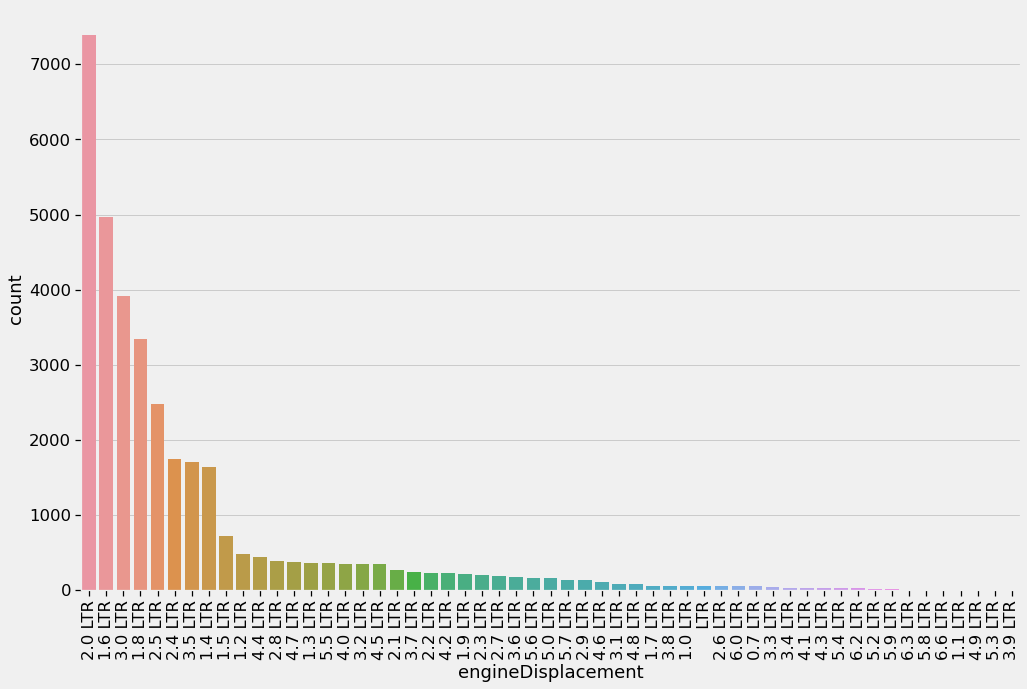

In [29]:
nominal_features("engineDisplacement", test, rotate=90, percentage=False)

In [30]:
print('В датасете представлены автомобили с {} различными объёмами двигателей\n'.format(len(test.engineDisplacement.unique())))

В датасете представлены автомобили с 55 различными объёмами двигателей



In [31]:
# какие 10 вариантов наиболее часто встречаются
count = Counter(test.engineDisplacement)
count.most_common(10)

[('2.0 LTR', 7391),
 ('1.6 LTR', 4973),
 ('3.0 LTR', 3915),
 ('1.8 LTR', 3349),
 ('2.5 LTR', 2477),
 ('2.4 LTR', 1745),
 ('3.5 LTR', 1710),
 ('1.4 LTR', 1635),
 ('1.5 LTR', 725),
 ('1.2 LTR', 485)]

In [32]:
# проверим какие автомобили имеют объём двигателя 0 литров
test[test['engineDisplacement'] == ' LTR'][['brand', 'model_name', 'fuelType']].iloc[3]

brand             BMW
model_name         I3
fuelType      электро
Name: 8350, dtype: object

В датасете очень большое разнообразие представленных объёмов двигателей автомобилей.
Наиболее часто встречающиеся объёмы от 1.2 до 3.5 литров.
Кроме того, есть предложения автомобилей с объёмом 0 литров. Очевидно, что это электромобили.
Сократить количество вариантов сложно и, вероятно, ухудшит результаты обучения модели.
Объём двигателя важная информация, влияющая как на итоговую цены предложения, так и возможность создания инсайтов.

In [33]:
powers = []
for value in test.enginePower:
    powers.append(int(value.split()[0]))

In [34]:
df_power = pd.DataFrame(powers, columns=['enginePower'], dtype=int)

min     30.000000
max    639.000000
25%    125.000000
50%    169.000000
75%    233.000000
std     89.087035
Name: enginePower, dtype: float64


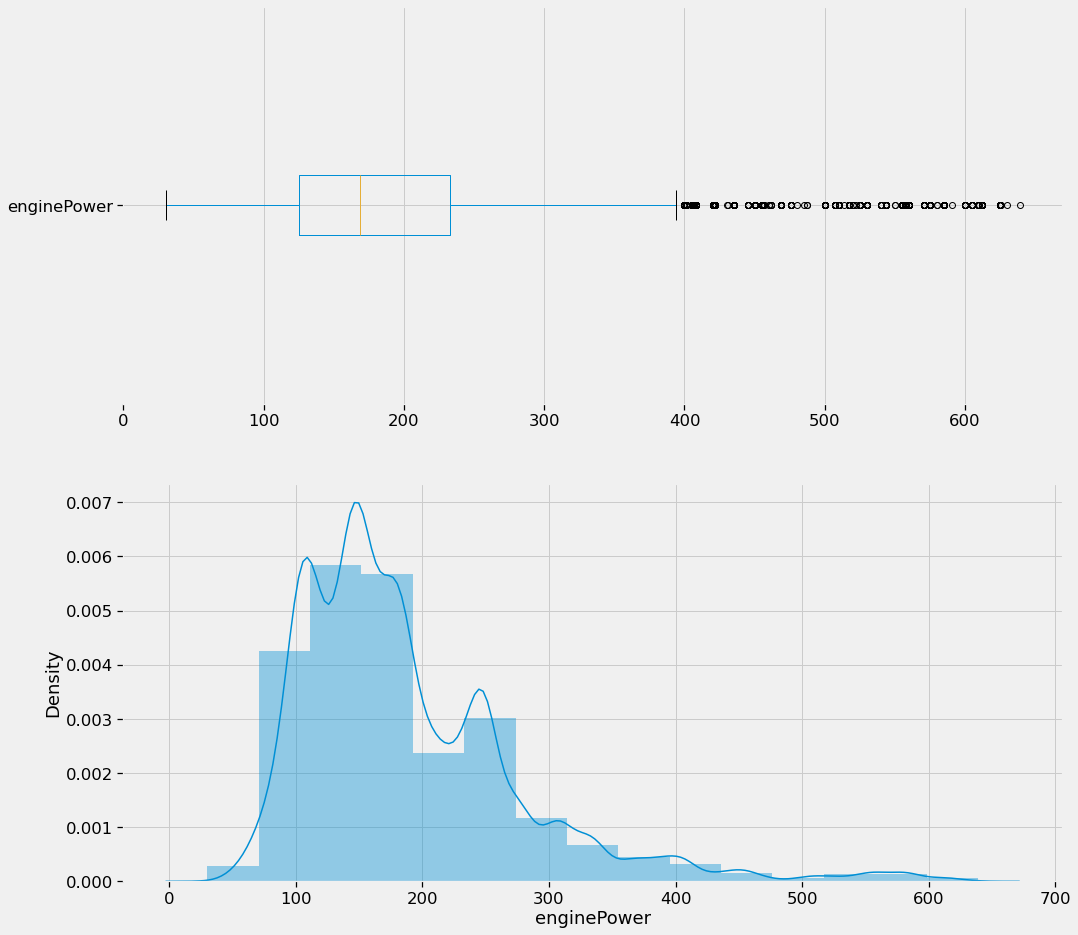

In [35]:
numeric_features(df_power, 'enginePower', bins=15)

In [36]:
print('В датасете представлены автомобили с {} различными мощностями двигателей\n'.format(len(test.enginePower.unique())))

В датасете представлены автомобили с 315 различными мощностями двигателей



In [37]:
# какие 10 вариантов наиболее часто встречаются
count = Counter(test.enginePower)
count.most_common(10)

[('249 N12', 1708),
 ('150 N12', 1699),
 ('110 N12', 1039),
 ('170 N12', 977),
 ('105 N12', 955),
 ('140 N12', 942),
 ('184 N12', 923),
 ('152 N12', 873),
 ('102 N12', 832),
 ('190 N12', 779)]

В датасете очень большое разнообразие представленных мощностей двигателей автомобилей. Возможно, это связано с тюнингом и доработками автомобилей их владельцами. Наиболее часто встречающиеся мощности 249 и 150 лошадиных сил. Мощность в пределах 150 - 250 л.с. самая характерная.

Мощность двигателя имеет прямую зависимость с размеров налога, уплачиваемого владельцем. Значит это важная информация, влияющая как на итоговую цены предложения. Сокращение количества вариантов, вероятно, ухудшит результаты обучения модели.

In [38]:
test.equipment_dict[10256]

'{"18-inch-wheels":true,"front-seats-heat":true,"park-assist-r":true}'

In [39]:
print('Признак "equipment_dict" имеет {} уникальных значений и {} пропущенных из {} имеющихся\n'
      .format(len(test.equipment_dict.unique()), test.equipment_dict.isna().sum(), len(test)))


Признак "equipment_dict" имеет 23706 уникальных значений и 9996 пропущенных из 34686 имеющихся



Признак 'equipment_dict' представляет собой булевый словарь распространённых опций автомобиля.
Представляет собой интерес с т.з. поиска инсайтов.

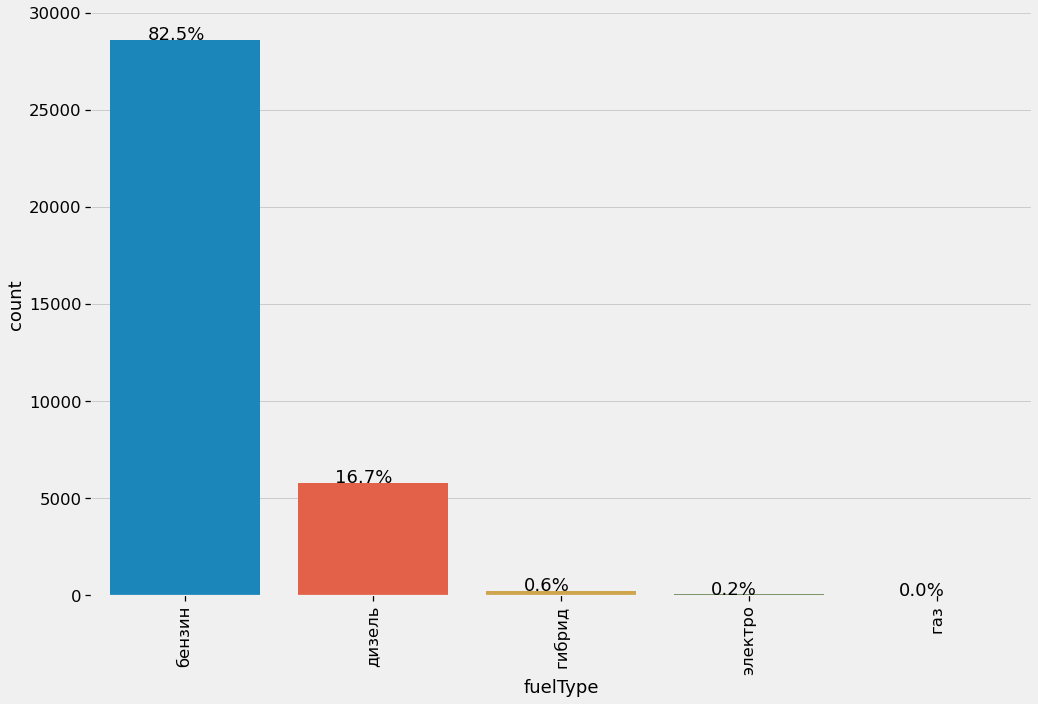

In [40]:
nominal_features("fuelType", test, rotate=90, x_shift_mult=1/4)

In [41]:
print('В датасете представлены двигатели {} типов по виду топлива\n'.format(len(test.fuelType.unique())))
test.fuelType.value_counts(normalize=False)

В датасете представлены двигатели 5 типов по виду топлива



бензин     28601
дизель      5800
гибрид       223
электро       55
газ            7
Name: fuelType, dtype: int64

В датасете представлены 5 типов двигателей по виду топлива.
Наиболее часто встречающиеся виды топлива: бензин и дизель.
Информация потенциально полезна для создания инсайтов в датасете.

min          1.000000
max    1000000.000000
25%      91153.500000
50%     149779.500000
75%     215000.000000
std     100676.559489
Name: mileage, dtype: float64


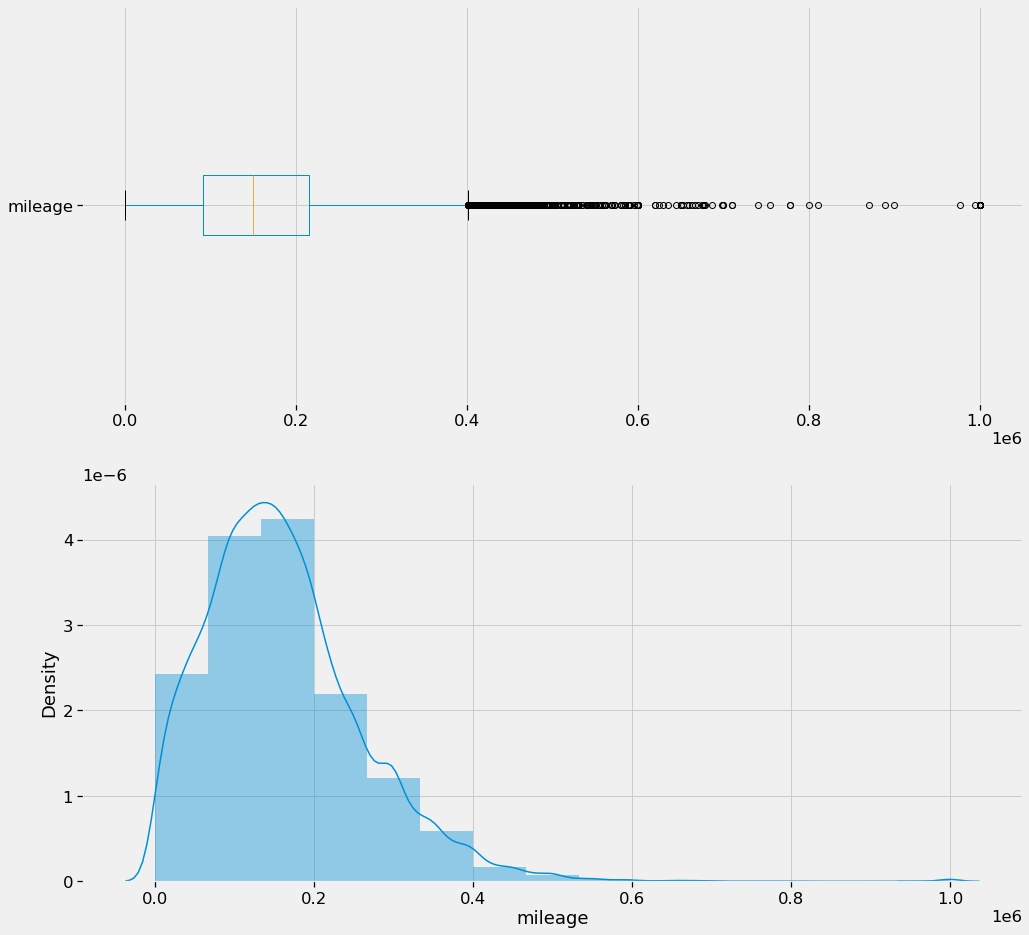

In [42]:
numeric_features(test, 'mileage', bins=15)

Пробег автомобилей в датасете варьируется от 1 до 1000000 км. Распределение признака логнормально, с тяжёлым правым "хвостом". Необходим дополнительный анализ по выбросам.

In [43]:
outliers(test, 'mileage')

В признаке 'mileage' есть значения, которые могут считаться выбросами
Количество выбросов в признаке 'mileage': 692.
Границы выбросов: [-94616.25, 400769.75], IQR: 123846.5


min    1904.000000
max    2020.000000
25%    2004.000000
50%    2008.000000
75%    2012.000000
std       7.415894
Name: modelDate, dtype: float64


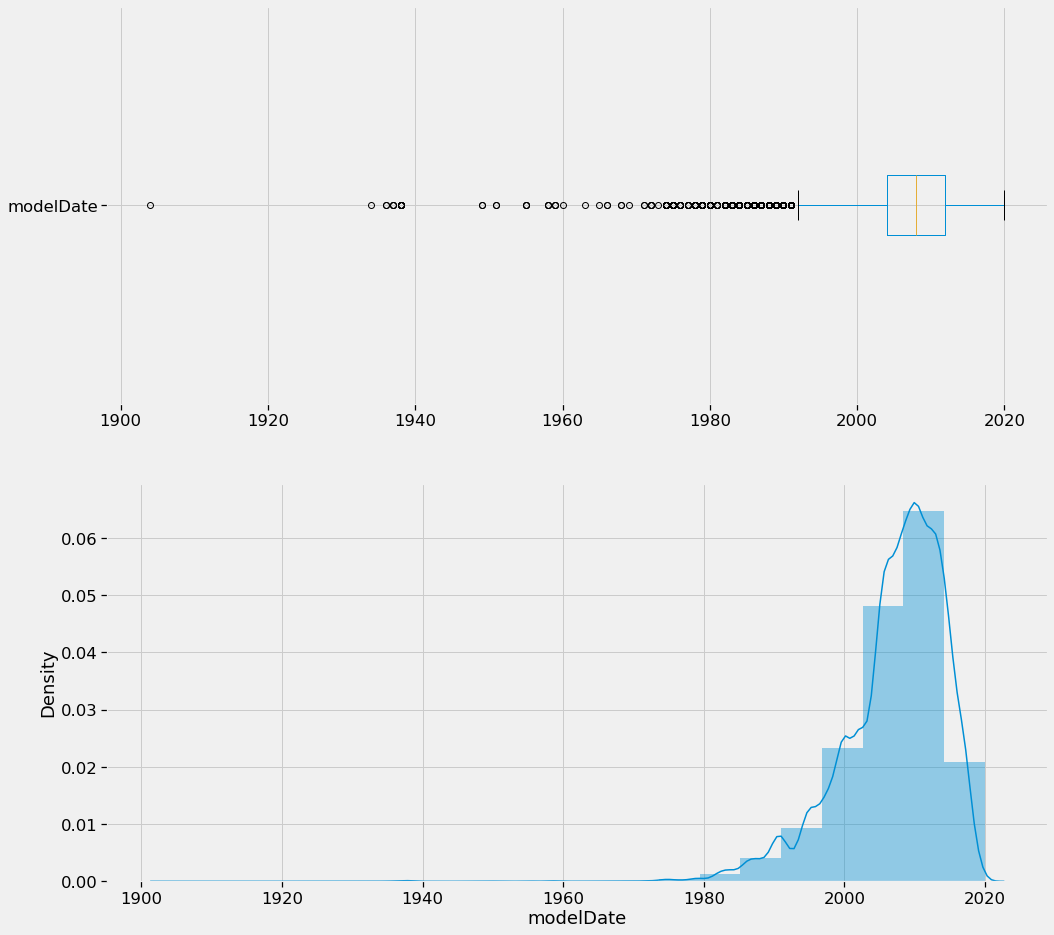

In [44]:
numeric_features(test, 'modelDate', bins=20)

Модельный год автомобилей в датасете варьируется от 1904 года до 2020 года. Основная масса представленных автомобилей имеет 2004 - 2012 модельные года. Распределение признака логнормально, с тяжёлым левым "хвостом". Необходим дополнительный анализ по выбросам. Однако, сам признак малоинформативен и сильно скоррелирован с признаком 'productionDate'. Предположительно, признак будет лишним для модели.

In [45]:
# проверим гипотезу о высокой корреляции
corr_coeff = np.array(test[['modelDate', 'productionDate']].corr())[0, 1]
print("Коэффициент корреляции Пирсона между признаками составляет {:.4f}.".format(corr_coeff))

Коэффициент корреляции Пирсона между признаками составляет 0.9743.


In [46]:
test.model_info[10256]

'{"code":"7ER","name":"7 серии","ru_name":"7 серии","morphology":{},"nameplate":{"code":"9264769","name":"745","semantic_url":"745"}}'

In [47]:
test.model_name[10256]

'7ER'

In [48]:
test.name[10256]

'745i 4.4 AT (333 л.с.)'

Судя по всему, признаки представляют собой дублирующуюся информацию и взаимосвязаны друг с другом.
Вся информация (за исключением 'model_name') есть в других признаках. Информация о названии модели теряет смысл при сравнени автомобилей разных брэндов. В этом случае используются другие критерии сравнения, н-р, возраст автомобиля, мощностьдвигателя, тип кузова, наличие опций и т.д. Для последующего обучения модели на тренировочной выборке необходимо будет избавиться от малоинформативных признаков.
Рабочая версия: убрать из модели все вышеназваные признаки.

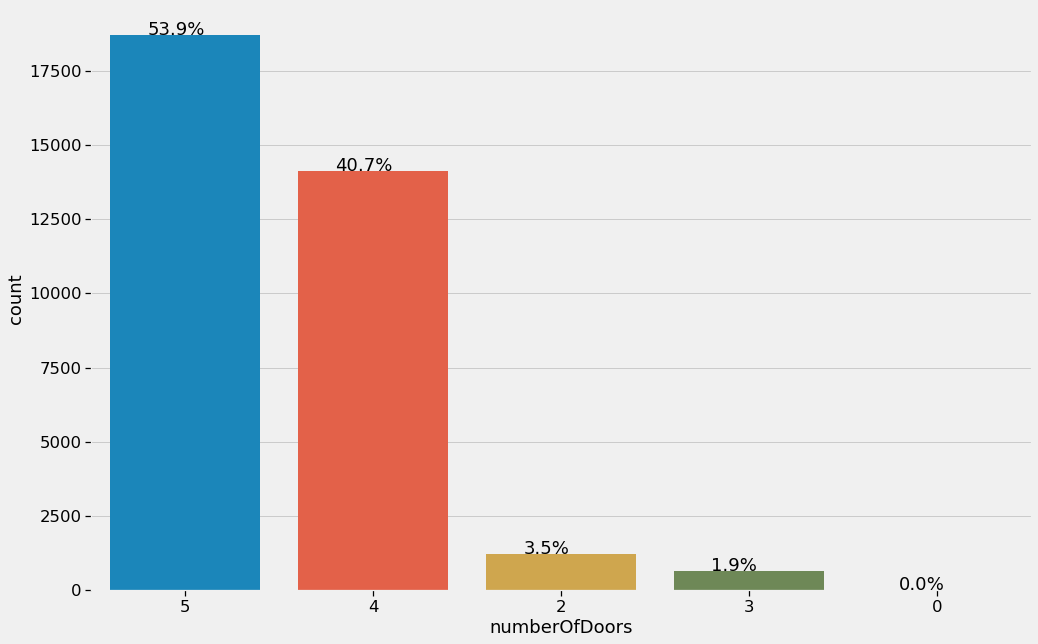

In [49]:
nominal_features("numberOfDoors", test, rotate=0, x_shift_mult=1/4)

min    1904.000000
max    2020.000000
25%    2006.000000
50%    2011.000000
75%    2014.000000
std       7.047661
Name: productionDate, dtype: float64


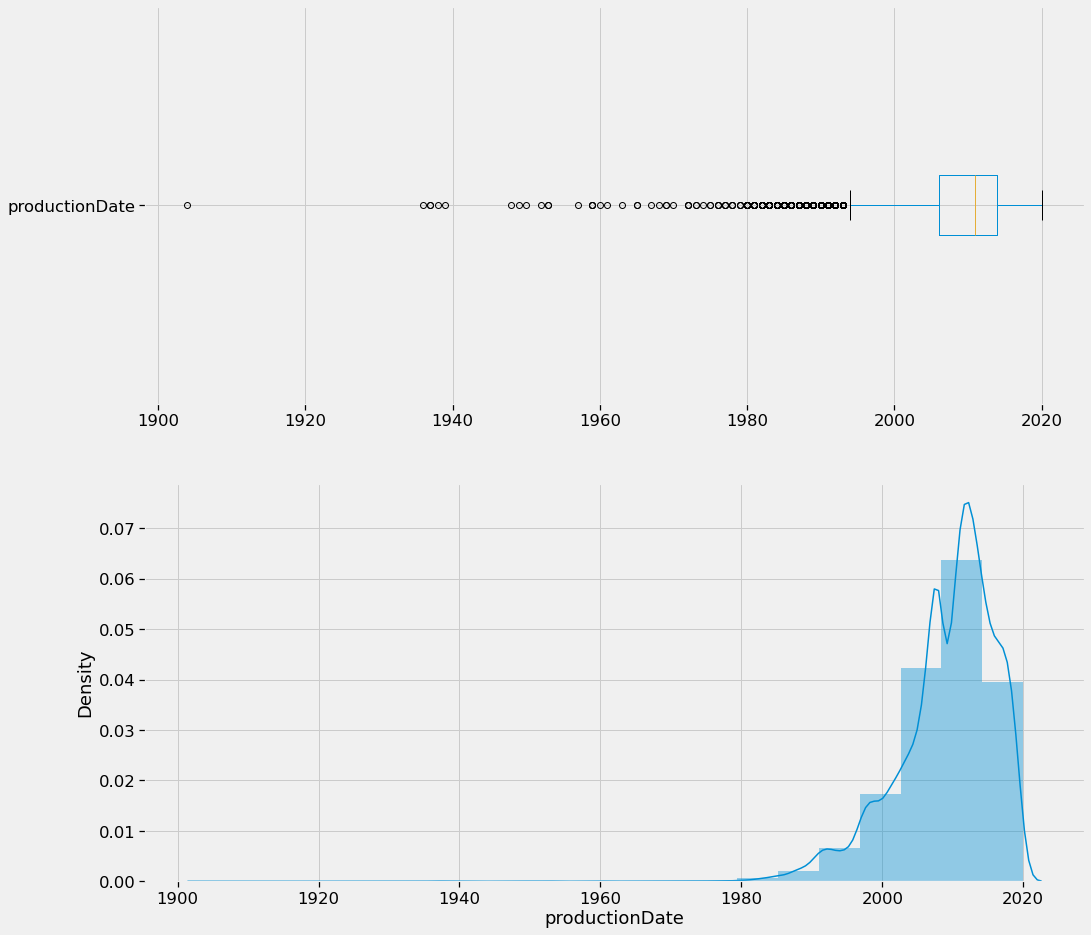

In [50]:
numeric_features(test, 'productionDate', bins=20)

Год производства имеет ассиметричное логнормальное распределение с длинным левым "хвостом". Самый старый автомобиль, представленный в датасете, выпущен в 1904 году, самый новый в 2020 году. Основная масса предложений лежит в периоде с 2006 по 2014 годы выпуска, т.е. возраст автомобилей в предложениях колеблется в основном от 6 до 14 лет. Кажется здесь также есть почва для создания новых признаков.

In [51]:
test.sell_id[10256]

1055814708

Признак 'sell_id' представляет собой некий служебный абсолютно уникальный идентификатор продавца в системе. Признак не представляет интереса для анализа и последующего использования в модели.

In [52]:
test.super_gen[10256]

'{"id":"20494546","name":"745","nameplate":"745i","displacement":4398,"engine_type":"GASOLINE","gear_type":"REAR_DRIVE","transmission":"AUTOMATIC","power":333,"power_kvt":245,"human_name":"745i 4.4 AT (333 л.с.)","acceleration":6.3,"clearance_min":120,"fuel_rate":10.9}'

Признак 'super_gen' представляет собой комбинацию (словарь) как уже имеющихся признаков в датасете, так и уникальной информации (н-р, расход топлива). Потенциально это может представлять интерес для дополнительного анализа.

In [53]:
test.vehicleConfiguration[10256]

'SEDAN AUTOMATIC 4.4'

Признак 'vehicleConfiguration' дублирует другие признаки (bodyType, vehicleTransmission, engineDisplacement), находящиеся в более удобном для обработки виде. В связи со значительной взаимосвязью признака с другими, является кандидатом на удаление в модели.

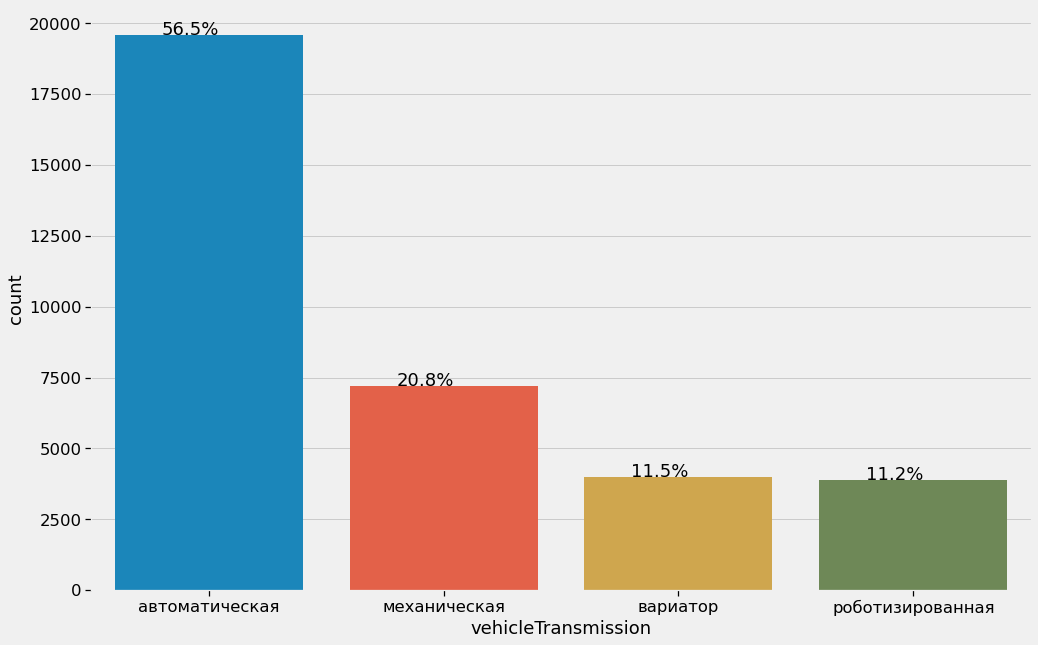

In [54]:
nominal_features("vehicleTransmission", test, rotate=0, x_shift_mult=1/4)

Более половины представленных в датасете автомобилей имеют автоматическую коробку передач. Всего в выборке имеется 4 варианта трансмиссии.

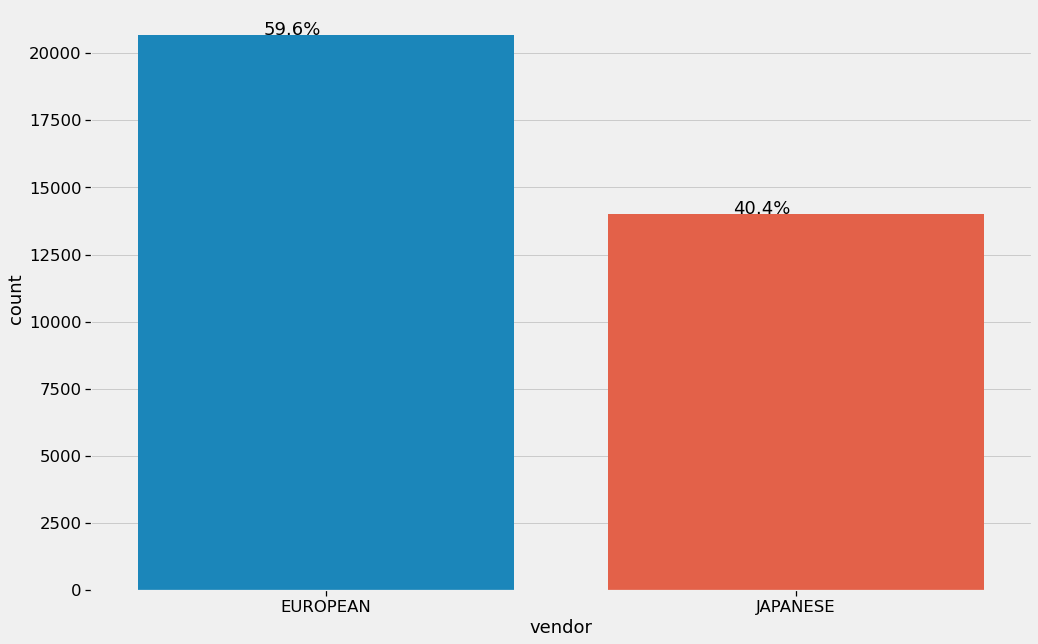

In [55]:
nominal_features("vendor", test, rotate=0, x_shift_mult=1/3)

Признак на страну торговой марки того или иного автомобиля, представленного в датасете. Хотя признак малоинформативен, он может оказать влияние на предсказание целевого признака.

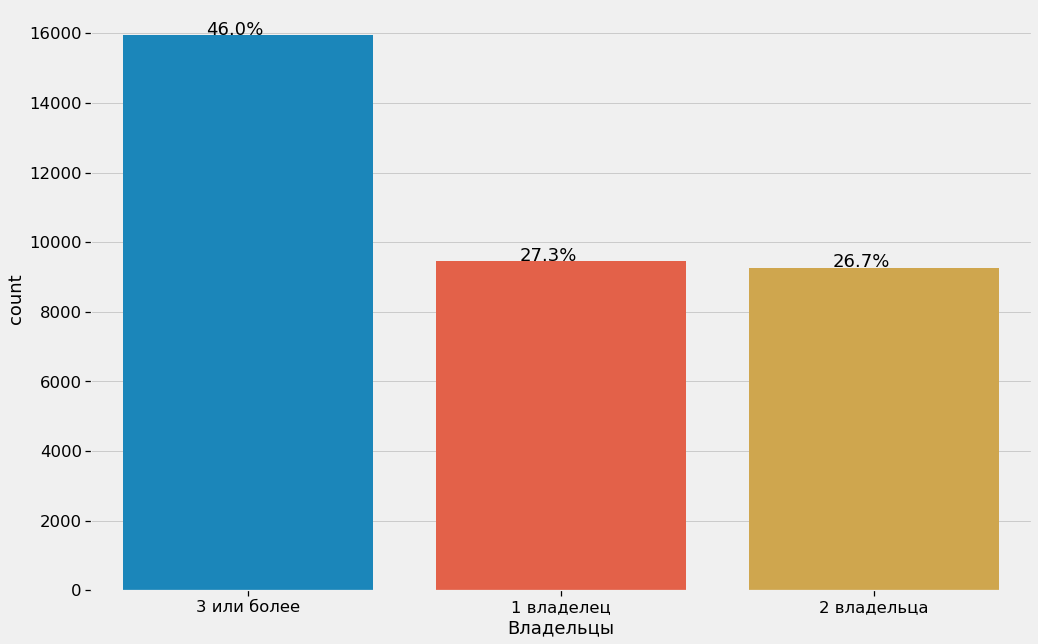

In [56]:
nominal_features("Владельцы", test, rotate=0, x_shift_mult=1/3)

In [57]:
test['Владение'][7093]

'1 год и 11 месяцев'

In [58]:
print('Признак "Владение" имеет {} уникальных значений и {} пропущенных из {} имеющихся\n'
      .format(len(test['Владение'].unique()), test['Владение'].isna().sum(), len(test)))


Признак "Владение" имеет 276 уникальных значений и 22691 пропущенных из 34686 имеющихся



Признак неинформативен, имеет слишком большое количество признаков. Предлагается к удалению.

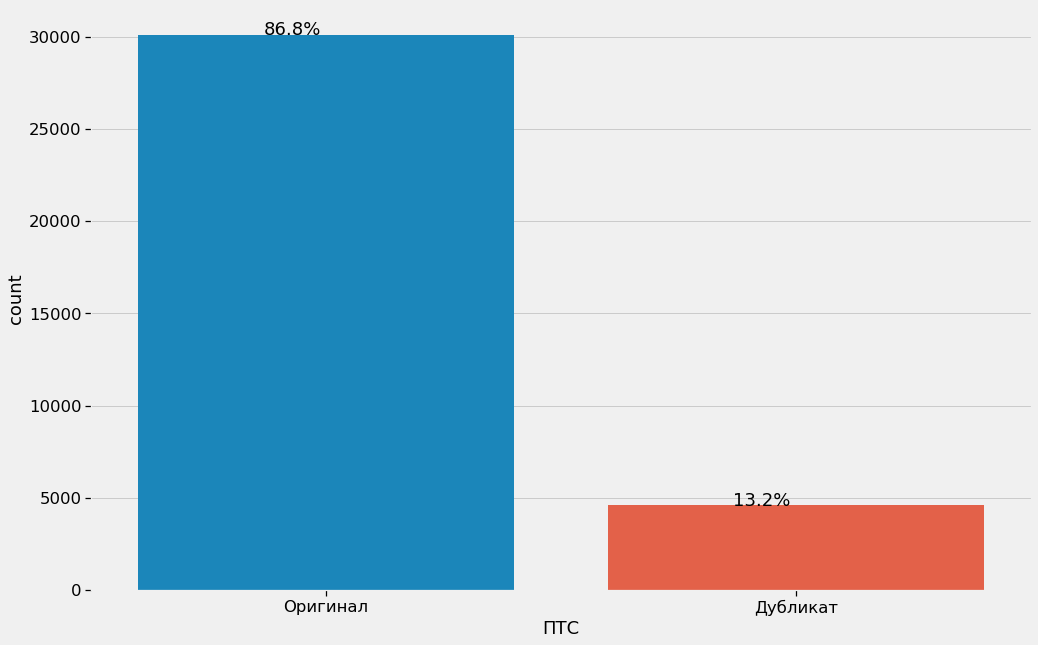

In [59]:
nominal_features("ПТС", test, rotate=0, x_shift_mult=1/3)

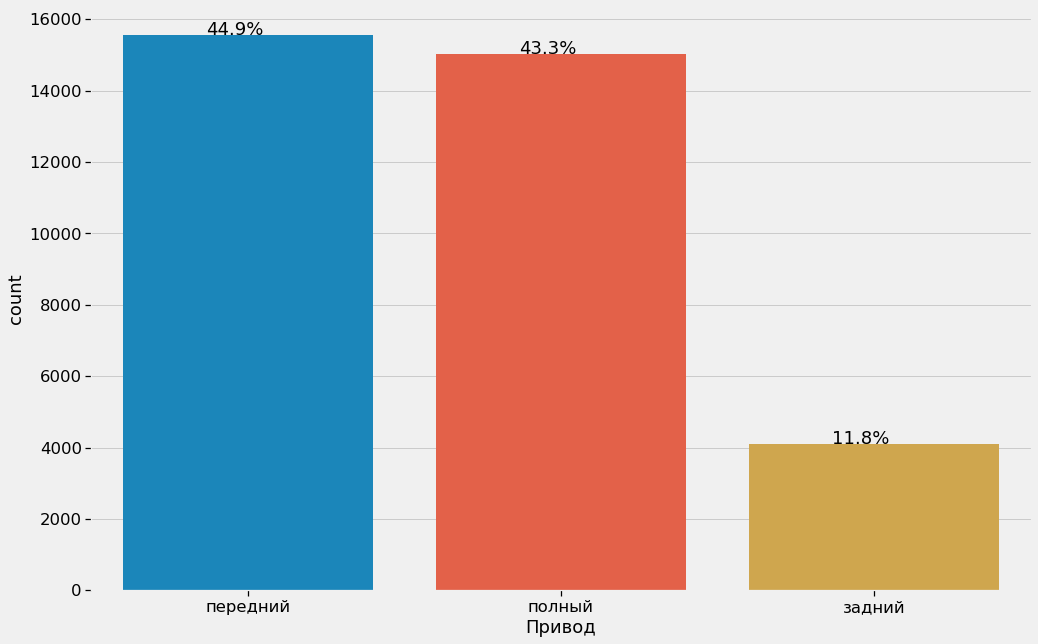

In [60]:
nominal_features("Привод", test, rotate=0, x_shift_mult=1/3)

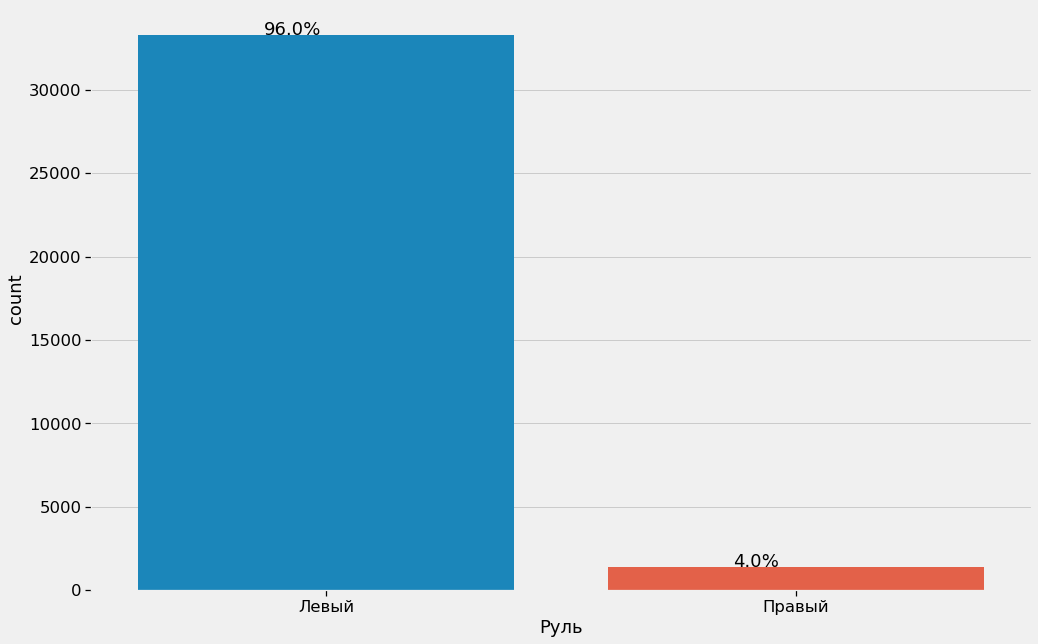

In [61]:
nominal_features("Руль", test, rotate=0, x_shift_mult=1/3)

### По предварительному анализу данных тестового датасета

- Датасет представляет собой довольно полное описание характеристик автомобиля. 
- Датасет представлен автомобилями 12 брендов, которые приблизительно поровну принадлежат европейским или японским вендорам.
- Данные, в основном, не содержат пропусков, за исключением признаков complectation_dict (missing 81.5%) и Владение (missing 65.4%).
- Некоторые признаки обладают низкой информативностью и высокой взаимосвязью с другими.
- Отдельные признаки дублируют данные, представленные в более удобном формате в других признаках.

Таким образом, предлагается:
1. Осуществить парсинг актуальных данных с сайта по сбору предложений о продаже бывших в употреблении автомобилей AUTO.RU
2. Сбор предложений осуществить по 12 брендам, представленным в тестовом датасете, по г.Москва с радиусом приближения 300 км.
3. Сбор предложений осуществить в формате аналогичном тестовому датасету плюс "ЦЕНА", как целевой признак.
4. Для цели подготовки модели для машинного обучения на следующем этапе исключить 15 из 32 признаков, фактически бесполезных для формирования будущей модели для прогнозирования цены автомобиля, а именно:
    - car_url 
    - complectation_dict
    - description
    - image
    - modelDate
    - model_info
    - model_name
    - name
    - parsing_unixtime
    - priceCurrency
    - sell_id
    - vehicleConfiguration
    - Владение
    - Состояние
    - Таможня
5. Остальные признаки дополнительно обработать, провезти анализ и попытаемся создать инсайты.

Проведённый разведывательный анализ тестового датасета, позволил нам понять имеющуюся структуру данных и определить набор информации, которую нам необходимо спарсить для подготовки тренировочного датасета.

### Parsing data auto.ru

Парсинг данных, осуществлем на локальной машине для ускорения процесса. В связи с этим, текст скрапера и последующее формирование тренировочного датасета опущено, но с ним можно свободно ознакомиться в моём репозитории на github


## EDA для тренировочного датасета и сравнение его с тестовым

### Проведём очистку данных в тренировочном датасете

In [62]:
print("Представленный датасет имеет {} повторяющихся строк.".format(train.duplicated().sum()))

Представленный датасет имеет 5 повторяющихся строк.


In [63]:
print("Представленный датасет имеет {} отсуствующих значений в целевом признаке.".format(train.price.isna().sum()))

Представленный датасет имеет 128 отсуствующих значений в целевом признаке.


Избавимся от дубликатов и предложений без цены для адекватности представляемой информации.

In [64]:
train.shape

(40952, 33)

In [65]:
amt = len(train)
train.drop_duplicates(inplace=True)
train.dropna(subset=['price'], inplace=True)

In [66]:
print('Количество удалённых строк в тренировочном датасете: {}'.format(amt - len(train)))

Количество удалённых строк в тренировочном датасете: 133


In [67]:
train.shape

(40819, 33)

In [68]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40819 entries, 0 to 40951
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              40817 non-null  object 
 1   brand                 40819 non-null  object 
 2   car_url               40819 non-null  object 
 3   color                 40819 non-null  object 
 4   complectation_dict    40819 non-null  object 
 5   description           40819 non-null  object 
 6   engineDisplacement    40819 non-null  object 
 7   enginePower           40819 non-null  object 
 8   equipment_dict        40819 non-null  object 
 9   fuelType              40817 non-null  object 
 10  image                 40819 non-null  object 
 11  mileage               36771 non-null  object 
 12  modelDate             40817 non-null  float64
 13  model_info            40819 non-null  object 
 14  model_name            40819 non-null  object 
 15  name               

ВАЖНО! По информации о датасете видно, что есть пропуски в ряде признаков, представляющися важными для создания модели.
Уберём строки с пропусками по очереди, начиная с признака 'bodyType'


In [69]:
train.dropna(subset=['bodyType'], inplace=True)

In [70]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40817 entries, 0 to 40951
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              40817 non-null  object 
 1   brand                 40817 non-null  object 
 2   car_url               40817 non-null  object 
 3   color                 40817 non-null  object 
 4   complectation_dict    40817 non-null  object 
 5   description           40817 non-null  object 
 6   engineDisplacement    40817 non-null  object 
 7   enginePower           40817 non-null  object 
 8   equipment_dict        40817 non-null  object 
 9   fuelType              40817 non-null  object 
 10  image                 40817 non-null  object 
 11  mileage               36769 non-null  object 
 12  modelDate             40817 non-null  float64
 13  model_info            40817 non-null  object 
 14  model_name            40817 non-null  object 
 15  name               

Именно те 2 строки, которые были удалены из датасета, имели пропуски почти по всем имеющимся признакам.

In [71]:
# проверка признаков датасета на неинформативность
informative(train)

priceCurrency: 100.00000%
RUB    40817
Name: priceCurrency, dtype: int64

Руль: 95.18338%
Левый     38851
Правый     1966
Name: Руль, dtype: int64

Состояние: 100.00000%
Не требует ремонта    40817
Name: Состояние, dtype: int64

Таможня: 100.00000%
Растаможен    40817
Name: Таможня, dtype: int64



Тренировочный датасет имеет те же неинформативные признаки, как и тестовый.

Сравним несколько категориальных признаков, представляющих интерес для последующей обработки, из имеющихся тестового и тренировочного датасетов для выявления различий.

In [72]:
cat_ft = [
    'bodyType', 
    'brand', 
    'color', 
    'engineDisplacement', 
    'enginePower', 
    'fuelType', 
    'numberOfDoors', 
    'vehicleTransmission',
    'Владельцы'
]

In [73]:
for feat in cat_ft:
    difs = get_differences(feat)


Train - Test differences in bodyType 

универсал 3 дв.    2
Name: bodyType, dtype: int64

Test - Train differences in bodyType 

фастбек    1
Name: bodyType, dtype: int64

Train - Test differences in brand 

No differences

Test - Train differences in brand 

No differences

Train - Test differences in color 

No differences

Test - Train differences in color 

No differences

Train - Test differences in engineDisplacement 

No differences

Test - Train differences in engineDisplacement 

No differences

Train - Test differences in enginePower 

410 N12    2
41 N12     1
477 N12    2
700 N12    1
161 N12    4
299 N12    1
344 N12    1
47 N12     1
187 N12    3
274 N12    1
196 N12    1
45 N12     2
25 N12     1
206 N12    1
Name: enginePower, dtype: int64

Test - Train differences in enginePower 

487 N12    2
38 N12     1
254 N12    1
338 N12    1
30 N12     1
402 N12    1
301 N12    1
514 N12    1
164 N12    1
61 N12     1
Name: enginePower, dtype: int64

Train - Test differences in

Промежуточный вывод: Отличия в признаках незначительны и при дальнейшей обработке не будут представлять проблемы.

ВАЖНО! В датасетах есть отличия в типах данных, которые нужно исправить. Ключевое, принципиально важное отличие: признак 'mileage' имеет не численный формат.

In [74]:
train.mileage.value_counts()

:200000    473
:300000    427
:250000    392
:150000    348
:160000    308
          ... 
:90800       1
:15747       1
:28263       1
:185922      1
:73561       1
Name: mileage, Length: 13159, dtype: int64

Вероятно, при парсинге данных был захвачен лишний символ. Избавимся от него и приведём признак к числовому формату.

In [75]:
train['mileage'] = train['mileage'].str.strip(':')

In [76]:
train['mileage'] = pd.to_numeric(train['mileage'], errors='coerce', downcast='float')

In [77]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40817 entries, 0 to 40951
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              40817 non-null  object 
 1   brand                 40817 non-null  object 
 2   car_url               40817 non-null  object 
 3   color                 40817 non-null  object 
 4   complectation_dict    40817 non-null  object 
 5   description           40817 non-null  object 
 6   engineDisplacement    40817 non-null  object 
 7   enginePower           40817 non-null  object 
 8   equipment_dict        40817 non-null  object 
 9   fuelType              40817 non-null  object 
 10  image                 40817 non-null  object 
 11  mileage               36769 non-null  float32
 12  modelDate             40817 non-null  float64
 13  model_info            40817 non-null  object 
 14  model_name            40817 non-null  object 
 15  name               

В предварительном анализе тестового датасета было выявлено большое количество выбросов по признаку 'productionDate'. 

Необходимо проверить в тренировочном. 

min    1904.000000
max    2020.000000
25%    2006.000000
50%    2011.000000
75%    2015.000000
std       7.407153
Name: productionDate, dtype: float64


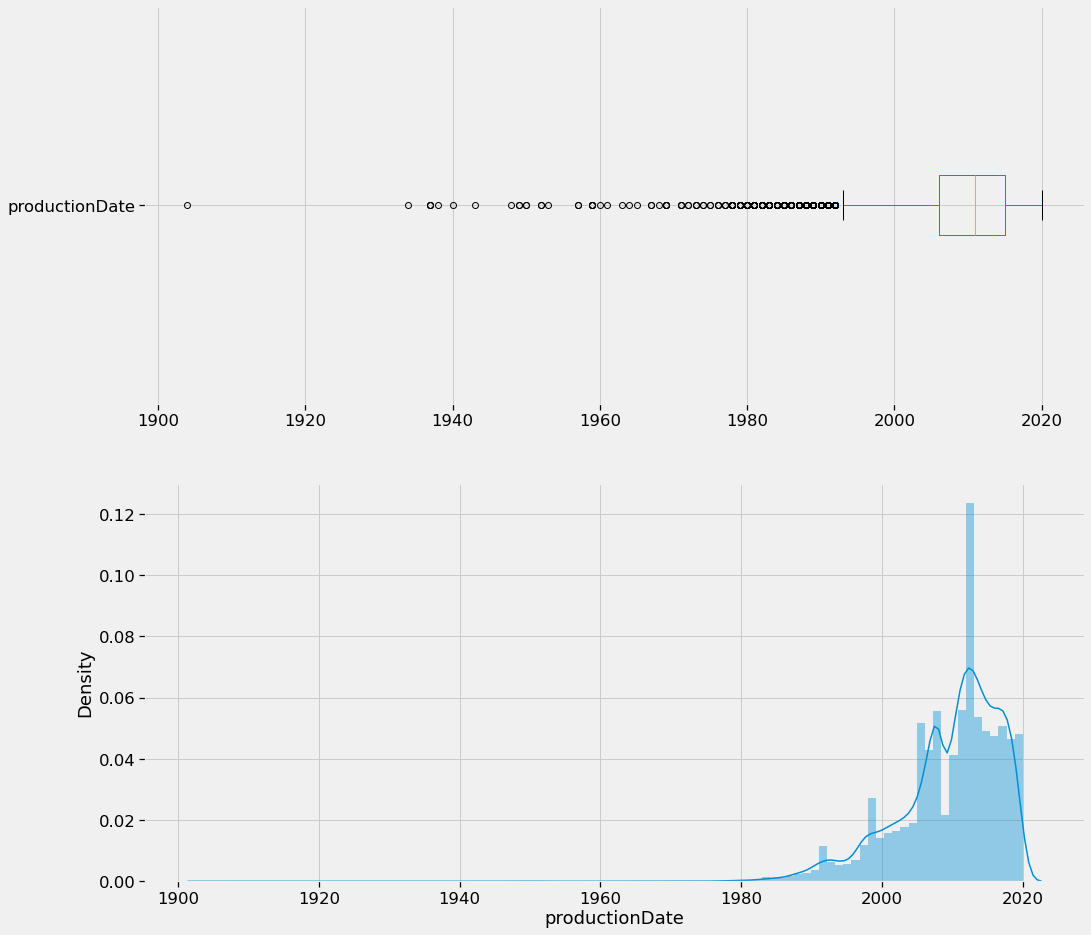

In [78]:
numeric_features(train, 'productionDate')

In [79]:
outliers(train, 'productionDate')

В признаке 'productionDate' есть значения, которые могут считаться выбросами
Количество выбросов в признаке 'productionDate': 1312.
Границы выбросов: [1992.5, 2028.5], IQR: 9.0


Проведём анализ имеющегося количества пропусков в признаках.

In [80]:
print('Доля пропусков в признаках: \n')
for col in train.columns:
    pct_missing = np.mean(train[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100, 2)))

Доля пропусков в признаках: 

bodyType - 0.0%
brand - 0.0%
car_url - 0.0%
color - 0.0%
complectation_dict - 0.0%
description - 0.0%
engineDisplacement - 0.0%
enginePower - 0.0%
equipment_dict - 0.0%
fuelType - 0.0%
image - 0.0%
mileage - 9.92%
modelDate - 0.0%
model_info - 0.0%
model_name - 0.0%
name - 0.0%
numberOfDoors - 0.0%
parsing_unixtime - 0.0%
price - 0.0%
priceCurrency - 0.0%
productionDate - 0.0%
sell_id - 0.0%
super_gen - 0.0%
vehicleConfiguration - 0.0%
vehicleTransmission - 0.0%
vendor - 0.0%
Владельцы - 0.01%
Владение - 69.16%
ПТС - 0.0%
Привод - 0.0%
Руль - 0.0%
Состояние - 0.0%
Таможня - 0.0%


In [81]:
# изменим dtype численных признаков для экономии ресурсов памяти
numeric_feat = ['modelDate', 'numberOfDoors', 'parsing_unixtime', 'productionDate', 'sell_id', 'price']
for col in numeric_feat:
    train[col] = train[col].astype("int32")

## Визуализация для целевого признака

In [82]:
# определим самый дорогой автомобиль датасета
train[train['price'] == train['price'].max()][['brand', 'name', 'fuelType', 'productionDate', 'mileage', 'price']]

brand               name fuelType  productionDate  mileage     price
14016  MERCEDES  3.0 MT (150 л.с.)   бензин            1952  12000.0  52500000

In [83]:
# и удалим его, как явный выброс
train = train.drop(index=[10264])

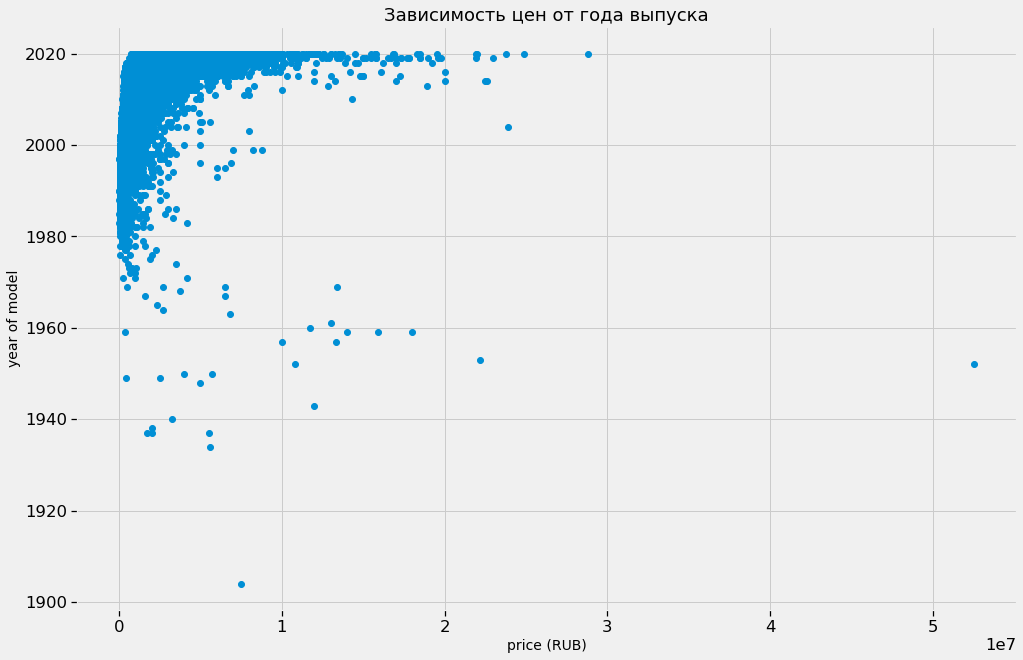

In [84]:
plt.scatter(train.price, train.productionDate)
plt.xlabel("price (RUB)", fontsize=14)
plt.ylabel("year of model", fontsize=14)
plt.title("Зависимость цен от года выпуска",fontsize=18)
plt.show()

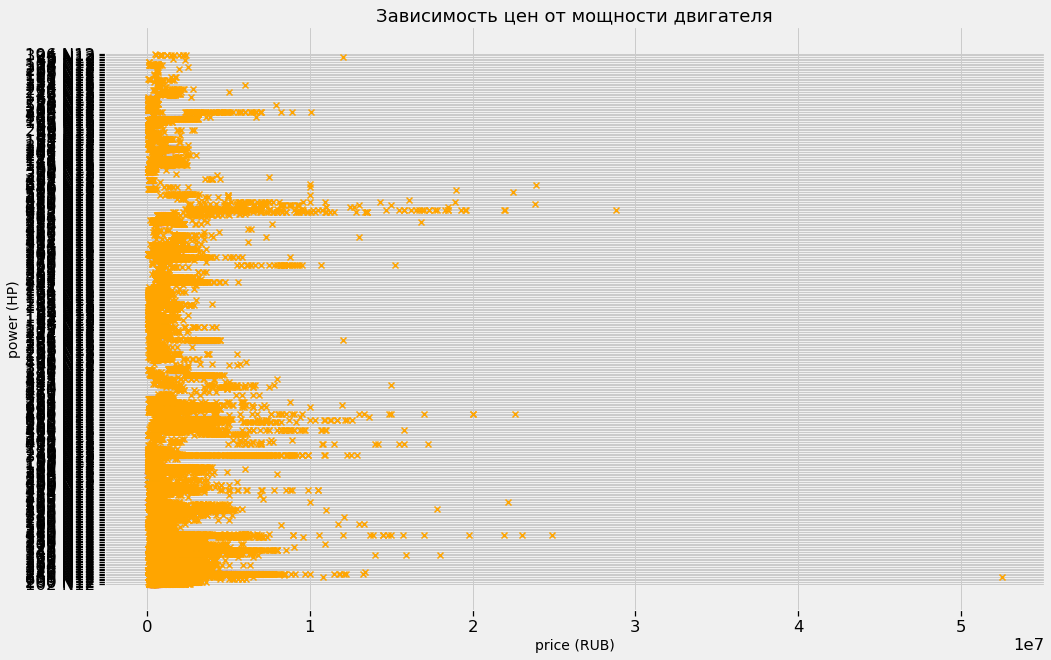

In [85]:
plt.scatter(train.price, train.enginePower, c='orange', marker='x')
plt.xlabel("price (RUB)", fontsize=14)
plt.ylabel("power (HP)", fontsize=14)
plt.title("Зависимость цен от мощности двигателя",fontsize=18)
plt.show()

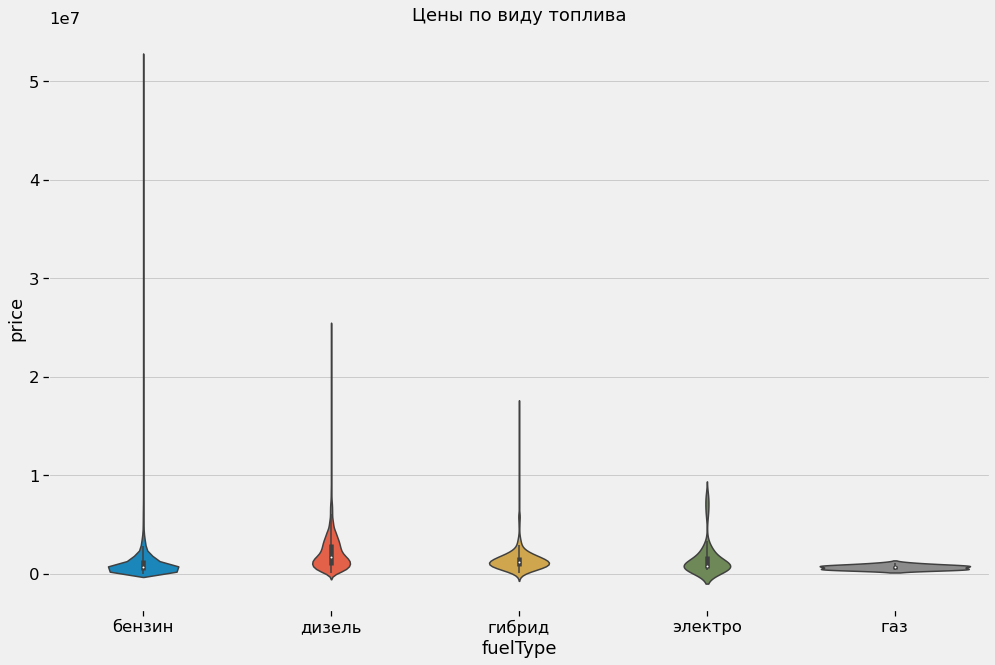

In [86]:
sns.violinplot(data = train, x='fuelType', y='price').set_title('Цены по виду топлива')
plt.show()

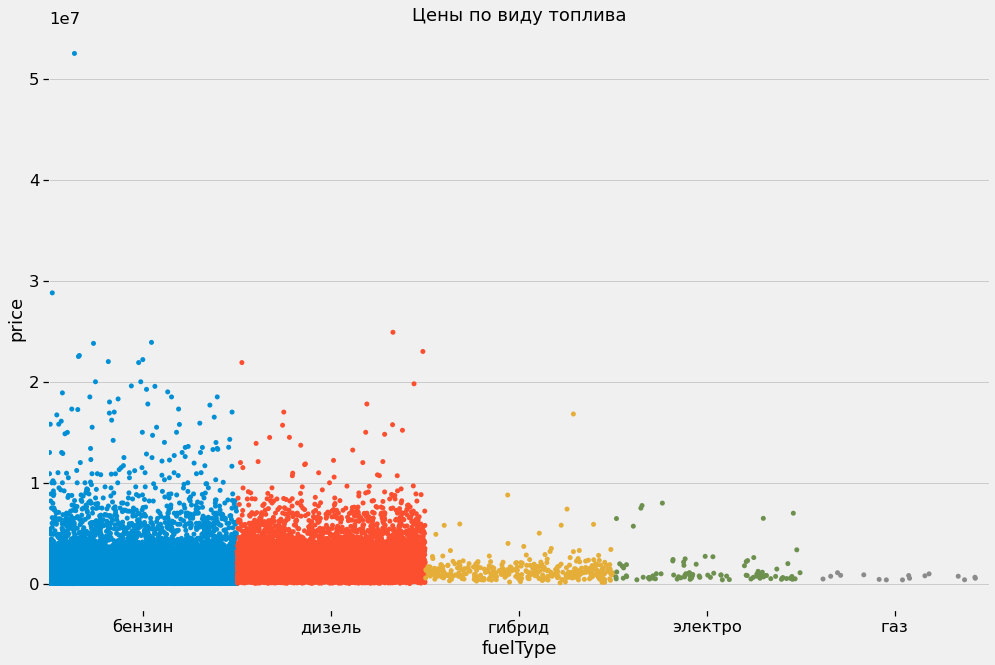

In [87]:
sns.stripplot(data = train, x='fuelType', y='price', jitter=.5).set_title('Цены по виду топлива')
plt.show()

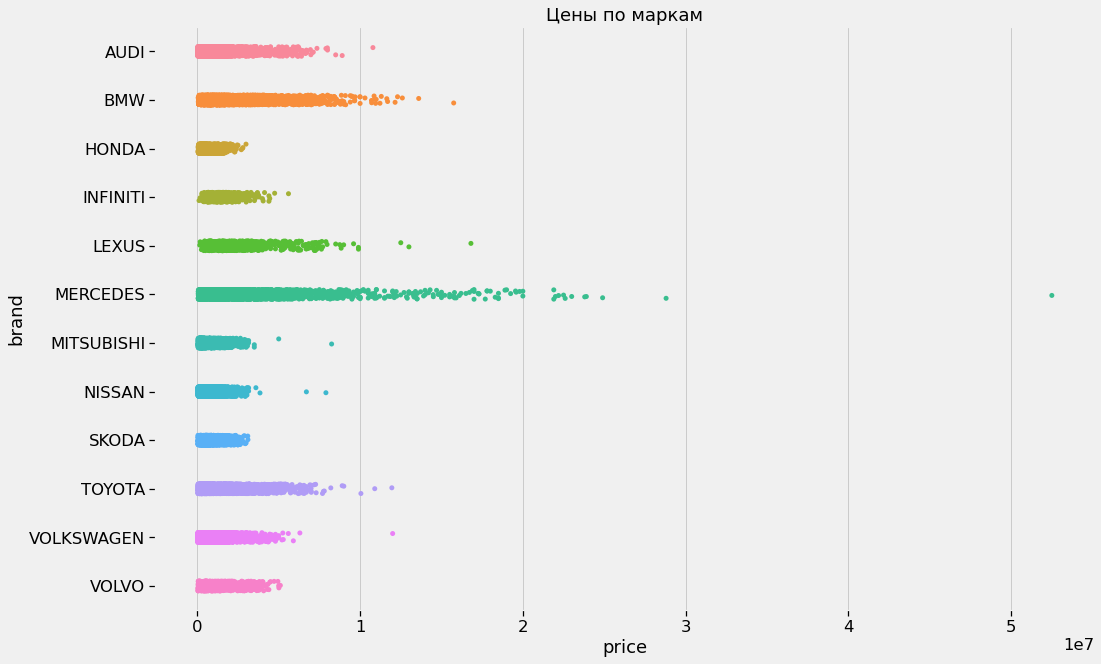

In [88]:
sns.stripplot(data = train, x='price', y='brand', jitter=.1).set_title('Цены по маркам')
plt.show()

min    2.000000e+04
max    5.250000e+07
25%    4.500000e+05
50%    8.490000e+05
75%    1.600000e+06
std    1.518672e+06
Name: price, dtype: float64


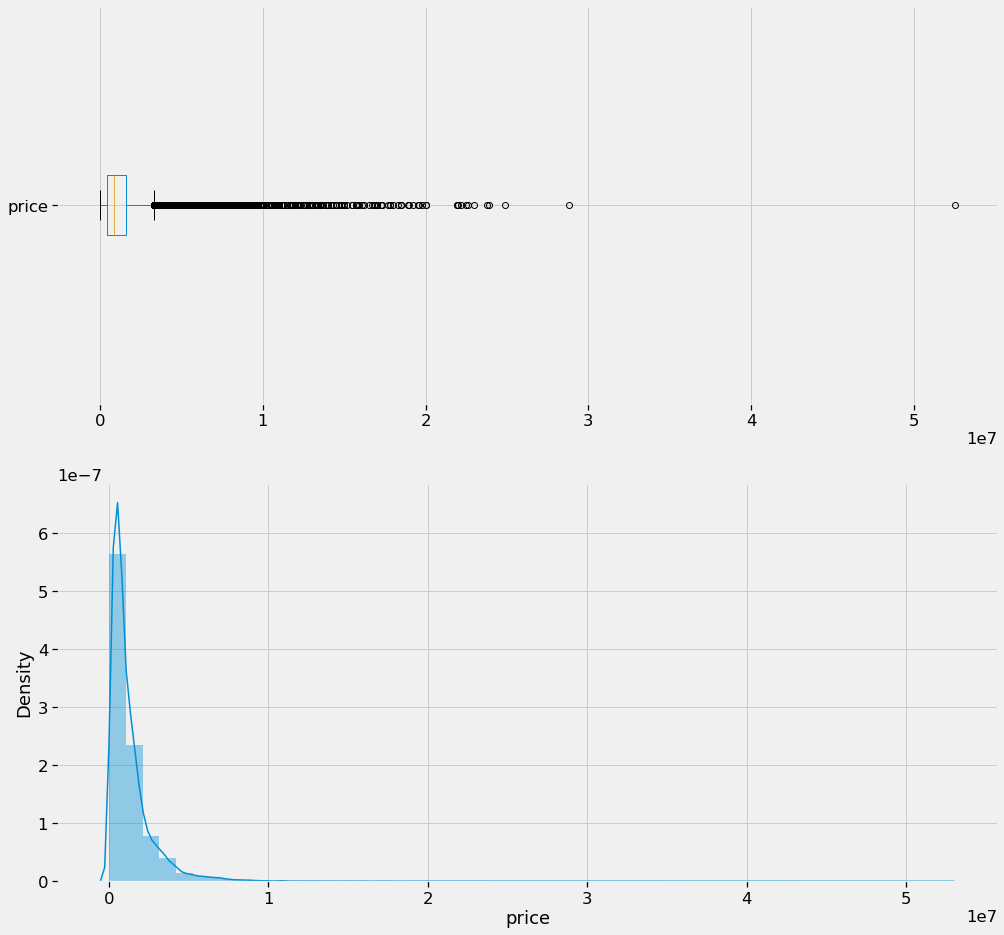

In [89]:
numeric_features(train, 'price', bins=50)

In [90]:
outliers(train, 'price')

В признаке 'price' есть значения, которые могут считаться выбросами
Количество выбросов в признаке 'price': 2983.
Границы выбросов: [-1275000.0, 3325000.0], IQR: 1150000.0


In [91]:
train['price'] = np.log(train["price"])

min     9.903488
max    17.776324
25%    13.017003
50%    13.651814
75%    14.285514
std     0.974057
Name: price, dtype: float64


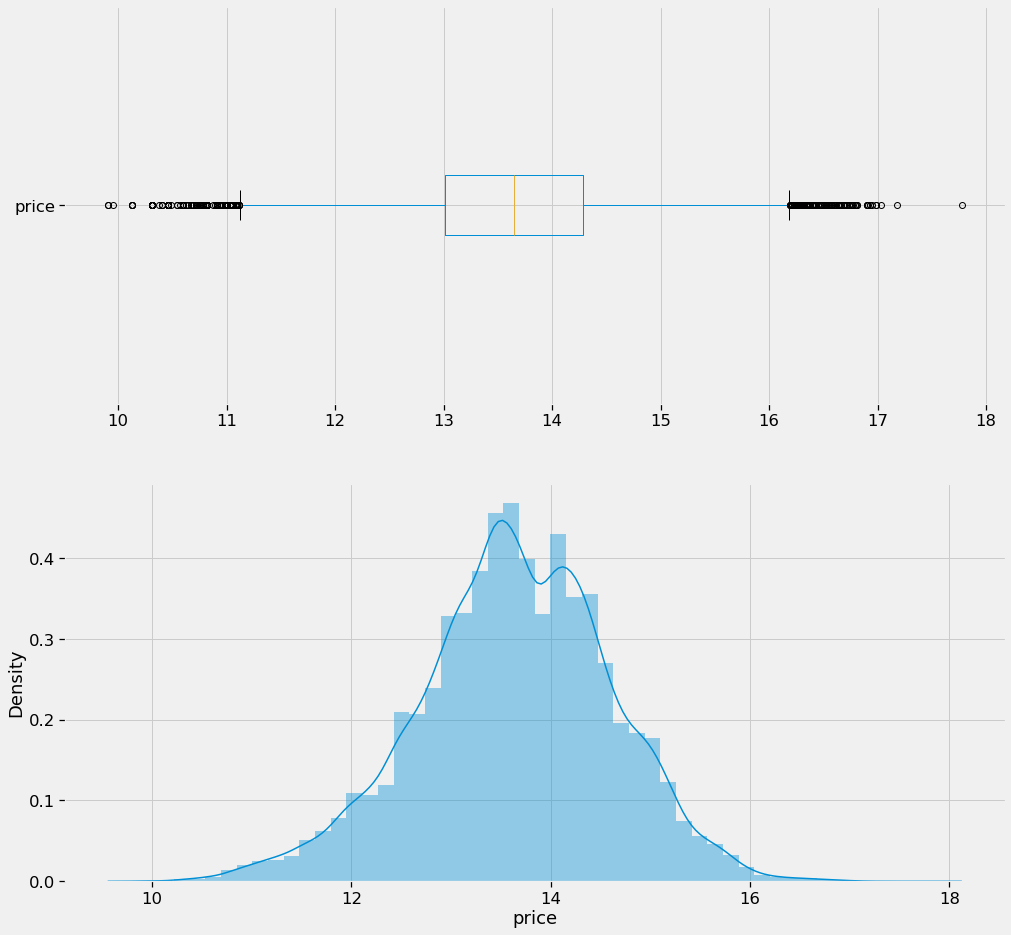

In [92]:
numeric_features(train, 'price', bins=50)

In [93]:
outliers(train, 'price')

В признаке 'price' есть значения, которые могут считаться выбросами
Количество выбросов в признаке 'price': 501.
Границы выбросов: [11.114235873551243, 16.188281175405272], IQR: 1.268511325463507


Распределение стало выглядеть значительно лучше. Количество выбросов уменьшилось.

Тренировочный датасет имеет такую же структуру, как и тестовый.
Можно приступать с предобработке и “фича-инжинирингу”

## Data Preprocessing

In [94]:
# проведём аналогичное изменение типов данных для тестового датасета...
numeric_feat.pop()

'price'

In [95]:
for col in numeric_feat:
    test[col] = test[col].astype("int32")

In [96]:
# и поменяем тип у 'mileage', чтобы была одинаковый тип данных и NaN не мешал
test['mileage'] = test['mileage'].astype("float32")

In [97]:
# назначим целевой признак, по которому будет проходить обучение
target = train['price']

In [98]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет

train['sample'] = 1   # помечаем где у нас трейн
test['sample'] = 0    # помечаем где у нас тест
test['price'] = 0     # в тесте у нас нет значения price


In [99]:
# объединяем датасеты

data = test.append(train, sort=False).reset_index(drop=True)   

Для признаков, которые будут удалены из-за большого количества пропусков, сохраним данные о пропусках

In [100]:
for col in ['complectation_dict', 'description', 'Владение']:
    data[col+'_isNAN'] = pd.isna(data[col]).astype('uint8')

Проведём короткий анализ текста в признаке 'description' и создадим дополнительный признак в датасете, основанный на частотной характеристике слов, входящих в описание.

In [101]:
# удалим все неинформативные признаки, отобранные на стадии предварительного анализа
feat2remove = [
    'car_url', 
    'complectation_dict', 
    'description', 
    'image', 
    'modelDate', 
    'model_info', 
    'model_name', 
    'name', 
    'parsing_unixtime', 
    'priceCurrency', 
    'sell_id', 
    'vehicleConfiguration', 
    'Владение', 
    'Состояние', 
    'Таможня'
]

In [102]:
data.drop(columns=feat2remove, inplace=True)

In [103]:
# проверим наличие дубликатов между тренировочным и тестовым датасетами
print("Объединёный датасет имеет {} повторяющихся строк.".format(data.duplicated().sum()))

Объединёный датасет имеет 289 повторяющихся строк.


In [104]:
# и удалим их (это невозможно, т.к. строки из тестового датасета)
# data.drop_duplicates(inplace=True)

In [105]:
data.sample(3)

bodyType   brand        color engineDisplacement enginePower  \
59615  хэтчбек 5 дв.  NISSAN  серебристый                LTR     109 N12   
65449          седан  TOYOTA        серый            2.5 LTR     181 N12   
40166          седан     BMW       чёрный            3.0 LTR     320 N12   

                                          equipment_dict fuelType   mileage  \
59615  {"cruise-control":true,"asr":true,"tinted-glas...  электро       NaN   
65449                                                 {}   бензин  112000.0   
40166  {"cruise-control":true,"esp":true,"sport-seats...   дизель  110500.0   

       numberOfDoors  productionDate  \
59615              5            2013   
65449              4            2015   
40166              4            2016   

                                               super_gen vehicleTransmission  \
59615  {"id":"20349043","name":"I (ZE0/AZE0)","ru_nam...      автоматическая   
65449  {"id":"20229979","name":"VII (XV50) Рестайлинг...      автоматическая   
40166  {"id":"20619259","name":"VI (G11/G12)","ru_nam...      автоматическая   

         vendor   Владельцы       ПТС    Привод    Руль  sample      price  \
59615  JAPANESE  1 владелец  Оригинал  передний  Правый       1  13.579788   
65449  JAPANESE  1 владелец  Оригинал  передний   Левый       1  14.253765   
40166  EUROPEAN  1 владелец  Оригинал    полный   Левый       1  14.994166   

       complectation_dict_isNAN  description_isNAN  Владение_isNAN  
59615                         0                  0               0  
65449                         0                  0               1  
40166                         0                  0               0

In [106]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75502 entries, 0 to 75501
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   bodyType                  75502 non-null  object 
 1   brand                     75502 non-null  object 
 2   color                     75502 non-null  object 
 3   engineDisplacement        75502 non-null  object 
 4   enginePower               75502 non-null  object 
 5   equipment_dict            65506 non-null  object 
 6   fuelType                  75502 non-null  object 
 7   mileage                   71454 non-null  float32
 8   numberOfDoors             75502 non-null  int32  
 9   productionDate            75502 non-null  int32  
 10  super_gen                 75502 non-null  object 
 11  vehicleTransmission       75502 non-null  object 
 12  vendor                    75502 non-null  object 
 13  Владельцы                 75499 non-null  object 
 14  ПТС   

In [107]:
# проверим у каких автомобилей отсутствует информация о ПТС
data[data['ПТС'].isna()][['brand', 'productionDate', 'Владельцы']]

brand  productionDate    Владельцы
10412       BMW            1999  3 или более
51738  MERCEDES            1997  3 или более

Очевидно, что при таком возрасте автомобиля и большом количестве владельцев,
ПТС мог быть утрачен. Заменяем пропуски значением "Дубликат"

In [108]:
data['ПТС'].fillna('Дубликат', inplace=True)

In [109]:
# проверим у каких автомобилей отсутствует информация о Владельцах
data[data['Владельцы'].isna()][['brand', 'productionDate', 'mileage']]

brand  productionDate   mileage
35547        AUDI            2001  160000.0
46545       LEXUS            2006  179000.0
71280  VOLKSWAGEN            1984   27500.0

Учитывая тот факт, что малое количество владельцев выглядит преимуществом при выборе подержанного автомобиля, а также большой возраст автомобилей и пробег (за исключением фантастического VW), заполним пропуски значением "3 или более", что представляется адекватным.

In [110]:
data['Владельцы'].fillna('3 или более', inplace=True)

Самый большой и самый сложный для заполнения признак - "mileage".     
Версия: заполнить пропуски средним значением пробега для соответствующего года. 

min    1904.000000
max    2020.000000
25%    2006.000000
50%    2011.000000
75%    2015.000000
std       7.246545
Name: productionDate, dtype: float64


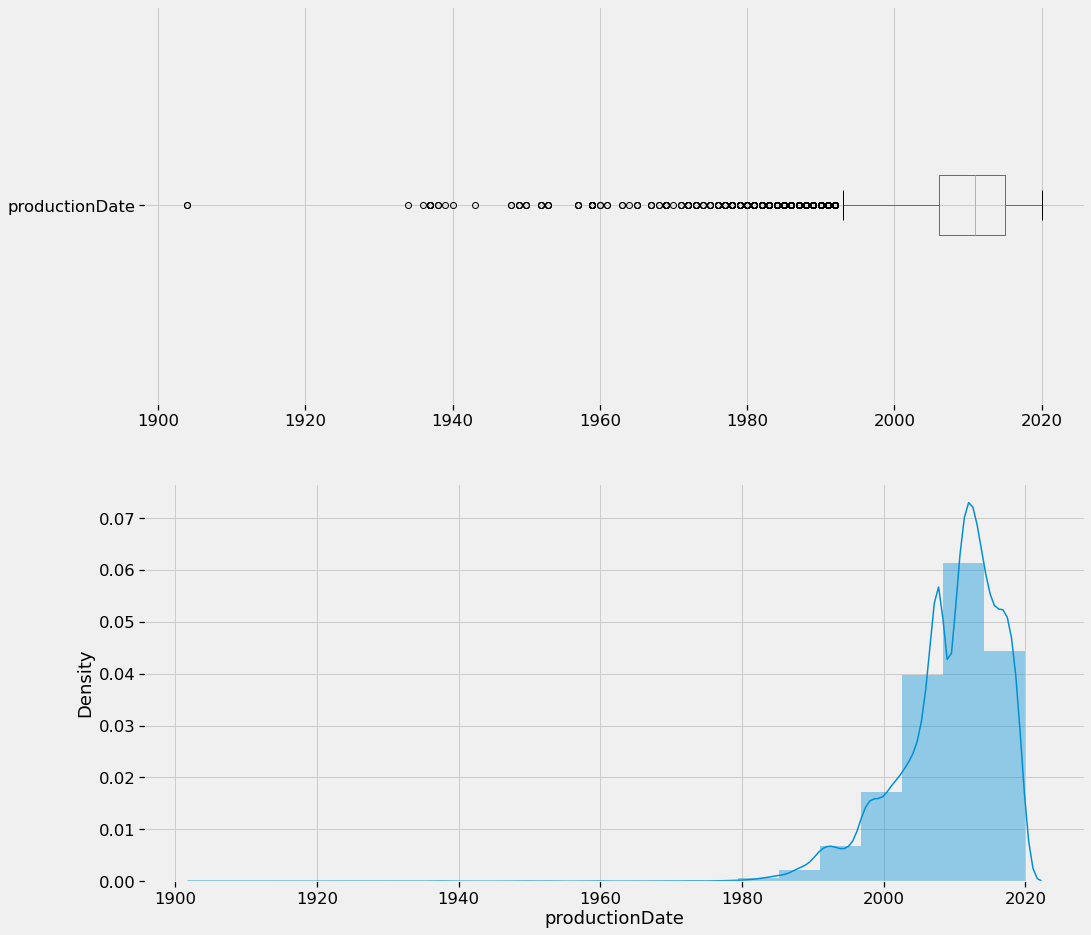

In [111]:
numeric_features(data, 'productionDate', bins=20)

In [112]:
# сохраним информацию о пропущеных значениях пробега
data['mileage_isNAN'] = pd.isna(data['mileage']).astype('uint8')

In [113]:
# заполним пропуски средним значением пробега для сответствующего года
data.mileage = data.groupby('productionDate').transform(lambda x: x.fillna(x.mean()))

In [114]:
# изменим тип данных
data.mileage = data.mileage.astype("int32")

min          1.000000
max    1000000.000000
25%      88000.000000
50%     147000.000000
75%     212000.000000
std     100305.782294
Name: mileage, dtype: float64


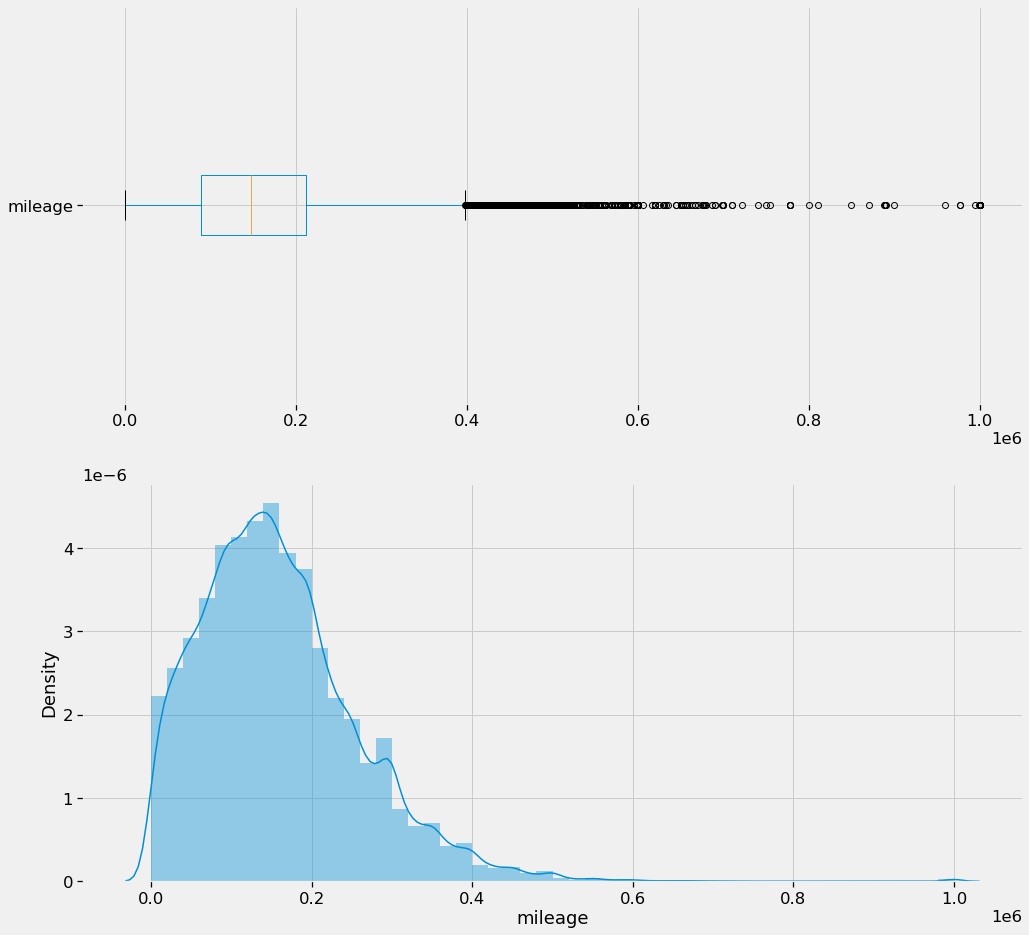

In [115]:
numeric_features(data, 'mileage', bins=50)

Где это возможно Переведём признаки  в численный формат.

Таких, очевидно, три: 'engineDisplacement', 'enginePower' и 'Владельцы

In [116]:
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: x.split()[0].strip() if x else None)
data.engineDisplacement = pd.to_numeric(data.engineDisplacement, errors = 'coerce', downcast = 'float')

In [117]:
# заменим на 0 пропуски, связанные с электродвигателями
data.engineDisplacement.fillna(0, inplace=True)

min    0.000000
max    6.600000
25%    1.800000
50%    2.000000
75%    3.000000
std    0.957888
Name: engineDisplacement, dtype: float64


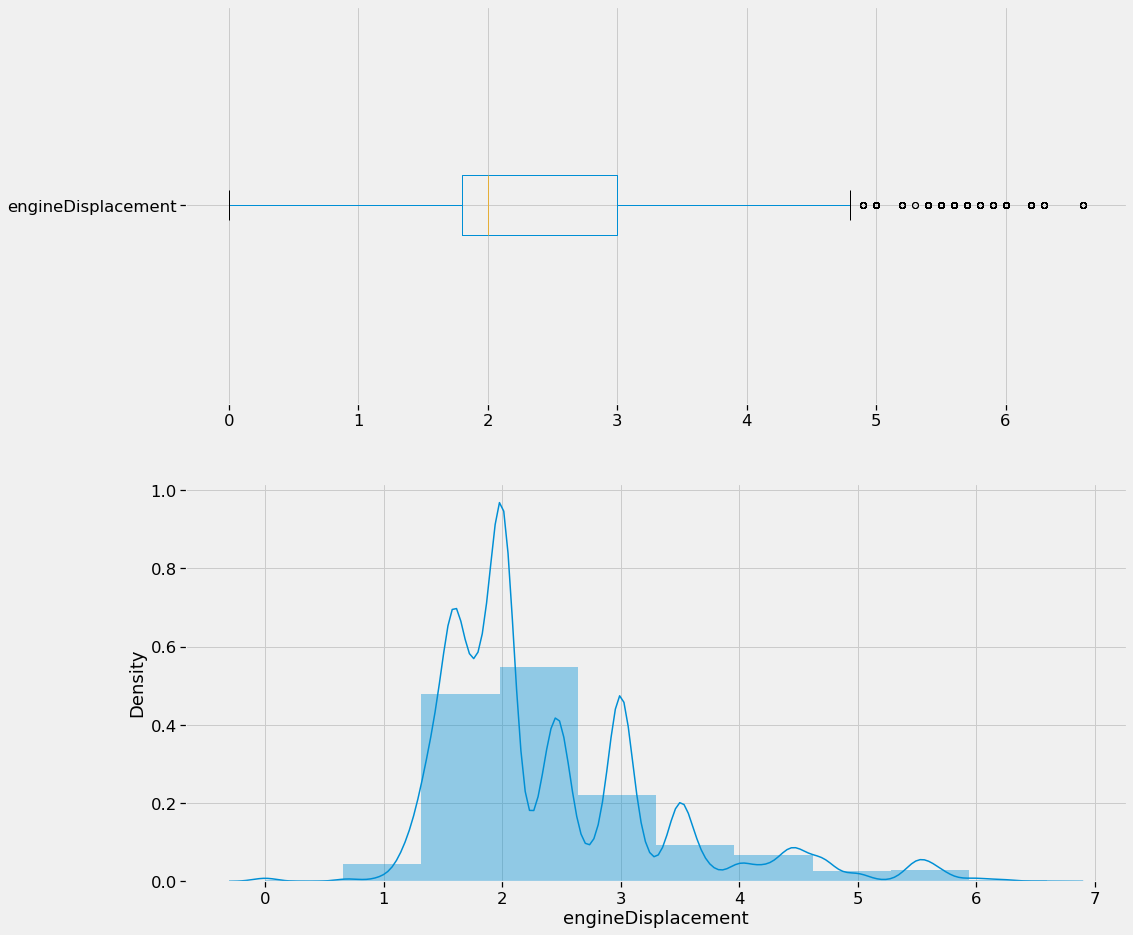

In [118]:
numeric_features(data, 'engineDisplacement', bins=10)

Разнообразия данных об объёме двигателя подталкивает к идеи трансформировать этот показатель из численного в ординальный. 

Для этого сделаем локальную функцию перевода с диапазонами подсказанными графиком.

In [119]:
def engine_vol(x):
    '''
    Функция используется для перевода численного 
    признака в упорядоченный категориальный 
    
    '''
    
    if x == 0: x = 0
    elif 0 < x <= 1.3: x = 1
    elif 1.3 < x <= 1.6: x = 2
    elif 1.6 < x <= 1.9: x = 3
    elif 1.9 < x <= 2.3: x = 4
    elif 2.3 < x <= 2.8: x = 5
    elif 2.8 < x <= 3.3: x = 6
    elif 3.3 < x <= 4.1: x = 7
    elif 4.1 < x <= 5.0: x = 8
    else: x = 9
    return x  

In [120]:
data.engineDisplacement = data.engineDisplacement.map(engine_vol)

<AxesSubplot:>

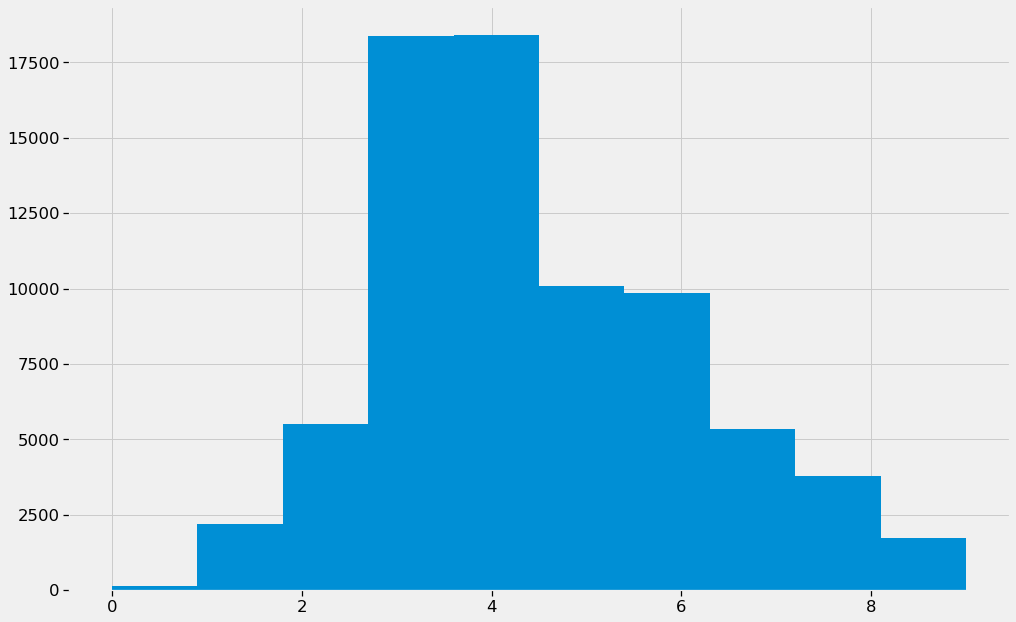

In [121]:
data.engineDisplacement.hist()

In [122]:
data['enginePower'] = data['enginePower'].apply(lambda x: x.split()[0].strip() if x else None)
data.enginePower = pd.to_numeric(data.enginePower, errors = 'coerce', downcast = 'integer')

In [123]:
data['Владельцы'].value_counts()

3 или более    34310
1 владелец     11877
2 владельца    10586
1 владелец      9459
2 владельца     9270
Name: Владельцы, dtype: int64

**NB!** Картина выглядит странно. Позже разберёмся почему так произошло. Сейчас это нам не помешает.

In [124]:
data['Владельцы'] = data['Владельцы'].apply(lambda x: x.split()[0].strip())
data['Владельцы'] = pd.to_numeric(data['Владельцы'], errors = 'coerce', downcast = 'integer')

### Создадим дополнительные признаки

In [125]:
# заполним пропуски в признаке equipment_dict для возможности дальнейшей обработки
data['equipment_dict'] = [{} if x != x else x for x in data['equipment_dict']]

In [126]:
# сохраним число дополнительных опций автомобиля из словаря в дополнительном признаке
data['optional_equipment'] = [len(x) for x in data['equipment_dict']]

In [127]:
# возраст автомобиля, исходя из даты производства
data['age_car'] = data['productionDate'].apply(lambda x: 2020 - x)

In [128]:
# статистический срок эксплуатации, исходя из оценки 17500 км в год
data['stat_age_car'] = data['mileage'].apply(lambda x: round(x / 17500))

In [129]:
data['expect_mileage'] = data['age_car'].apply(lambda x: round(x * 17500))

In [130]:
# пробег в год за время эксплуатации
def mileage_per_year(x, y):
    if x == 0:
        return 0
    elif y == 0:
        return x
    else:
        return round(x / y)


In [131]:
data['mileage_per_year'] = data.apply(lambda x: mileage_per_year(x.mileage, x.age_car), axis=1)


min         0.000000
max    131000.000000
25%     11892.000000
50%     15789.000000
75%     20588.000000
std      9573.119299
Name: mileage_per_year, dtype: float64


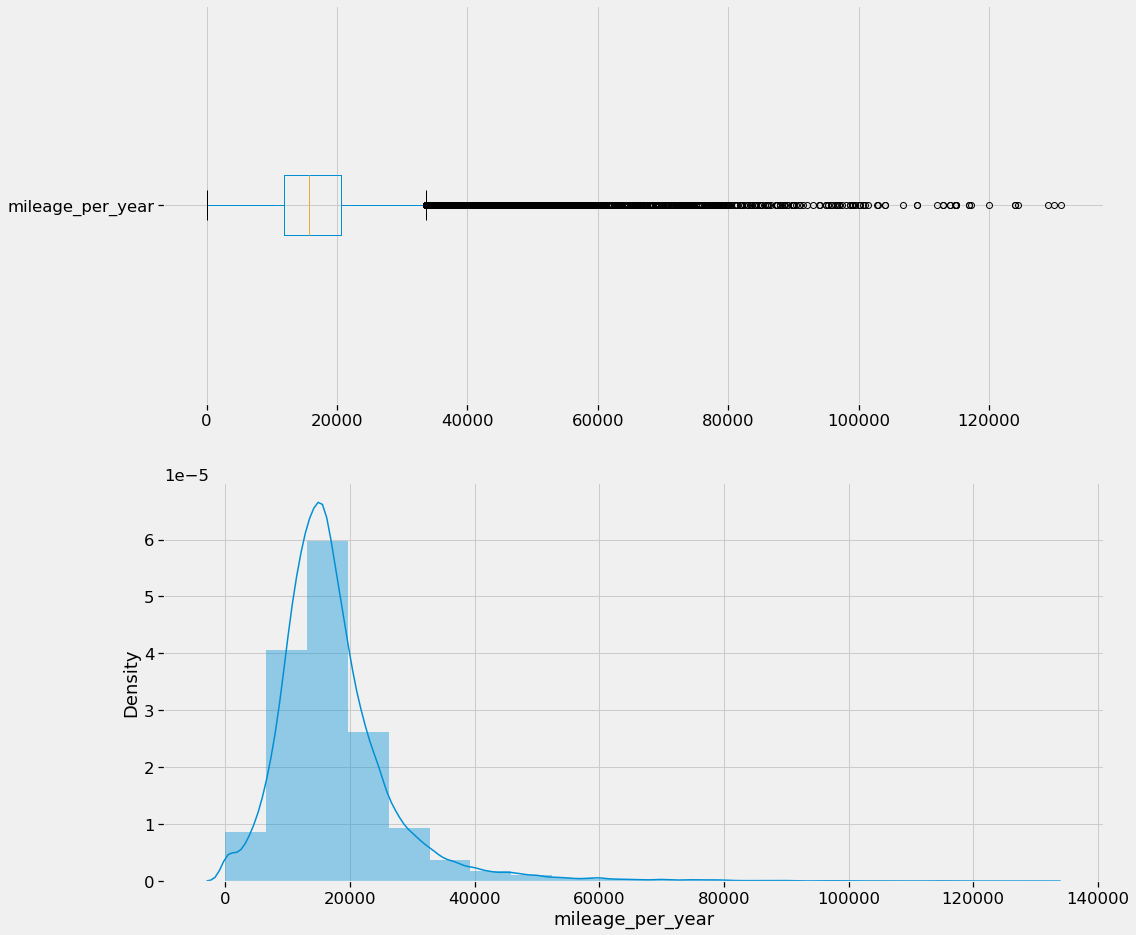

In [132]:
numeric_features(data, 'mileage_per_year', bins=20)

In [133]:
outliers(data, 'mileage_per_year')

В признаке 'mileage_per_year' есть значения, которые могут считаться выбросами
Количество выбросов в признаке 'mileage_per_year': 3709.
Границы выбросов: [-1152.0, 33632.0], IQR: 8696.0


In [134]:
# определим автомобили из датасета, с нереальным годовым пробегом
data[data['mileage_per_year'] > 110000][['brand', 'fuelType', 'productionDate', 'mileage', 'price']]

brand fuelType  productionDate  mileage      price
1468        SKODA   бензин            2018   240000   0.000000
1488        SKODA   бензин            2019   117000   0.000000
9695          BMW   дизель            2019   112000   0.000000
18248    MERCEDES   бензин            2019   115000   0.000000
26127  VOLKSWAGEN   бензин            2019   117257   0.000000
27556  MITSUBISHI   бензин            2012   995200   0.000000
30680  VOLKSWAGEN   бензин            2017   345005   0.000000
31172       SKODA   бензин            2019   124000   0.000000
31194       SKODA   бензин            2017   342000   0.000000
34073       SKODA   бензин            2019   114000   0.000000
41463         BMW   бензин            2019   130000  14.686804
41520         BMW   дизель            2019   129000  14.762438
50124    MERCEDES   бензин            2019   115000  14.771022
61055       SKODA   бензин            2019   131000  13.698977
61476       SKODA   бензин            2019   124000  13.676248
61543       SKODA   бензин            2017   344150  13.270783
62649       SKODA   бензин            2019   112928  13.573439
69098  VOLKSWAGEN   бензин            2019   116981  15.067702
69959  VOLKSWAGEN   бензин            2019   113000  13.304685

Скорее всего, данные автомобили имели коммерческой использование. 

Это представляется ценной информацией для будущей модели.

<AxesSubplot:>

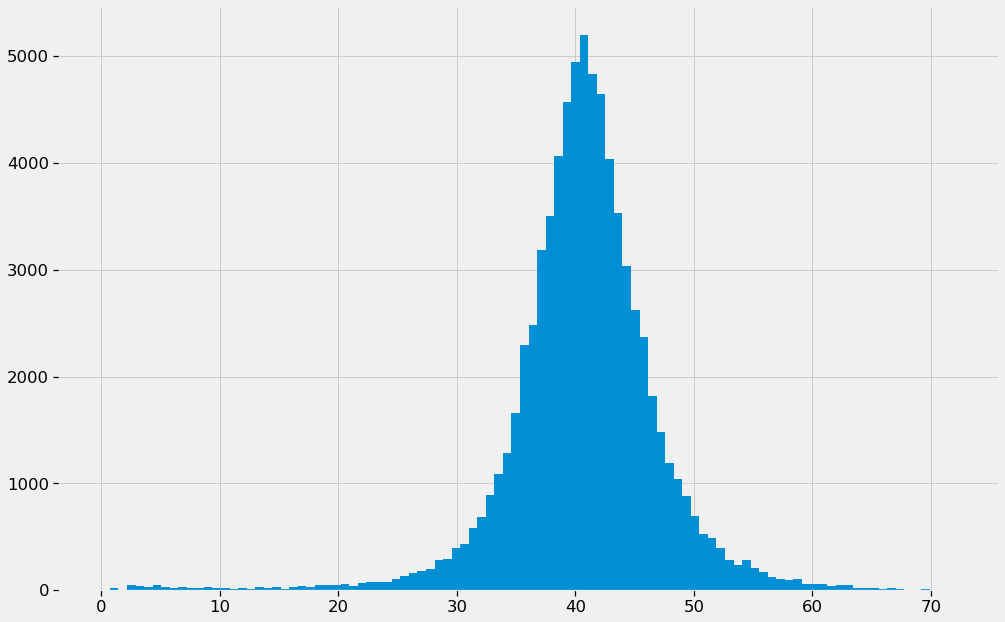

In [135]:
# необходимо провести логарифмирование признака для улучшения распределения
boxcox1p(data.mileage_per_year, 0.25).hist(bins=100)

In [136]:
data['mileage_per_year'] = boxcox1p(data['mileage_per_year'], 0.25)

In [137]:
# округлим данные чтобы убрать float
data['mileage_per_year'] = data['mileage_per_year'].apply(lambda x: round(x * 100))
# data.mileage_per_year = data.mileage_per_year.astype("int32")

In [138]:
# преобразуем избранные числовые признаки в полиномиальные
col_num = ['mileage', 'expect_mileage']
poly = PolynomialFeatures(2, interaction_only=True)
data_num = pd.DataFrame(poly.fit_transform(data[col_num].values))

In [139]:
data_num.columns = ['X', 'polyMile', 'polyExptd', 'polyFeat']
data_num.drop(columns='X', inplace=True)

In [140]:
# прологарифмируем полученные полиномиальные признаки
data_num = np.log(data_num +1)

In [141]:
# округлим данные чтобы убрать float
for col in data_num.columns:
    data_num[col] = data_num[col].apply(lambda x: round(x * 100))

In [142]:
data = pd.concat([data, data_num], axis=1)

In [143]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75502 entries, 0 to 75501
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   bodyType                  75502 non-null  object 
 1   brand                     75502 non-null  object 
 2   color                     75502 non-null  object 
 3   engineDisplacement        75502 non-null  int64  
 4   enginePower               75502 non-null  int16  
 5   equipment_dict            75502 non-null  object 
 6   fuelType                  75502 non-null  object 
 7   mileage                   75502 non-null  int32  
 8   numberOfDoors             75502 non-null  int32  
 9   productionDate            75502 non-null  int32  
 10  super_gen                 75502 non-null  object 
 11  vehicleTransmission       75502 non-null  object 
 12  vendor                    75502 non-null  object 
 13  Владельцы                 75502 non-null  int8   
 14  ПТС   

In [144]:
# датасет не имеет пропусков и полностью готов для дальнейшей обработки
# сохраним копию для быстрого восстановления при необходимости для различных видов обучения
df_orig = data.copy(deep=True)

## Label Encoding

В датасете присутствуют большое количество категориальные переменные и для регрессионных моделей, которые необходимо будет использовать для машинного обучения, необходимо сделать перевод этих переменных в числовые. 

In [145]:
# проведём категориальное сопоставление для признаков с большим кол-вом значений
for col in ['bodyType', 'brand', 'color']:
    data[col] = data[col].astype('category').cat.codes

In [146]:
# для бинарных категориальных признаков проведём обычное кодирование
le = LabelEncoder()
for col in ['vendor', 'ПТС', 'Руль']:
    le.fit(data[col])
    data[col] = le.transform(data[col])


In [147]:
# для отдельных признаков м.б. ложная иерархия, поэтому применим dummy-кодирование 
dummy_feat_names = ['fuelType', 'vehicleTransmission', 'gearType']

In [148]:
# переименуем переменные для избежания коллизий
gear_dict = {
    'передний': "forward", 
    'полный': "full", 
    'задний': "rear"
}
data['gearType'] = data['Привод'].map(gear_dict)
data.drop(columns='Привод', inplace=True)

transmission_dict = {
    'автоматическая': "automatic", 
    'механическая': "mechanical", 
    'роботизированная': "robot", 
    'вариатор': "variator"
}
data['vehicleTransmission'] = data['vehicleTransmission'].map(transmission_dict)

fuel_dict = {
    'бензин': "petrol",
    'дизель': "diesel", 
    'гибрид': "hibrid", 
    'электро': "electro", 
    'газ': "lpg"
}
data['fuelType'] = data['fuelType'].map(fuel_dict)

In [149]:
# "горячее" кодирование
for col in dummy_feat_names:
    one_hot = pd.get_dummies(data[col], prefix=data[col].name)  # одно горячее кодирование столбцов  
    data = data.drop(col,axis = 1)  # удалить столбец в том виде, в котором он закодирован
    data = data.join(one_hot)  # Присоединяйтесь к закодированному df
   

In [150]:
# сохраним число характеристик из словаря super_gen в дополнительном признаке
data['super_gen_idx'] = [len(x) for x in data['super_gen']]

In [151]:
# и удалим признаки, содержащие словари
dic_feat_names = ['equipment_dict', 'super_gen']
data.drop(columns=dic_feat_names, inplace=True)

In [152]:
# контроль
data.sample(3)


bodyType  brand  color  engineDisplacement  enginePower  mileage  \
36176        15      0      1                   3          170    74000   
31043         8      8      1                   4          200   170000   
19049        15      9     15                   5          181    21161   

       numberOfDoors  productionDate  vendor  Владельцы  ПТС  Руль  sample  \
36176              4            2012       0          3    1     0       1   
31043              5            2012       0          3    1     0       0   
19049              4            2019       1          1    1     0       0   

           price  complectation_dict_isNAN  description_isNAN  Владение_isNAN  \
36176  13.854731                         0                  0               0   
31043   0.000000                         0                  0               0   
19049   0.000000                         1                  0               1   

       mileage_isNAN  optional_equipment  age_car  stat_age_car  \
36176              0                1136        8             4   
31043              0                 778        8            10   
19049              0                 468        1             1   

       expect_mileage  mileage_per_year  polyMile  polyExptd  polyFeat  \
36176          140000              3523      1121       1185      2306   
31043          140000              4430      1204       1185      2389   
19049           17500              4424       996        977      1973   

       fuelType_diesel  fuelType_electro  fuelType_hibrid  fuelType_lpg  \
36176                0                 0                0             0   
31043                0                 0                0             0   
19049                0                 0                0             0   

       fuelType_petrol  vehicleTransmission_automatic  \
36176                1                              0   
31043                1                              0   
19049                1                              1   

       vehicleTransmission_mechanical  vehicleTransmission_robot  \
36176                               0                          0   
31043                               0                          1   
19049                               0                          0   

       vehicleTransmission_variator  gearType_forward  gearType_full  \
36176                             1                 1              0   
31043                             0                 1              0   
19049                             0                 1              0   

       gearType_rear  super_gen_idx  
36176              0            132  
31043              0            231  
19049              0            215

In [153]:
data.shape

(75502, 39)

In [154]:
# для baseline просто возьму пару схожих признаков без полной обработки
# columns = ['bodyType', 'brand', 'productionDate', 'engineDisplacement', 'mileage']
# df_train = train[columns]
# df_test = test[columns]

In [155]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75502 entries, 0 to 75501
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   bodyType                        75502 non-null  int8   
 1   brand                           75502 non-null  int8   
 2   color                           75502 non-null  int8   
 3   engineDisplacement              75502 non-null  int64  
 4   enginePower                     75502 non-null  int16  
 5   mileage                         75502 non-null  int32  
 6   numberOfDoors                   75502 non-null  int32  
 7   productionDate                  75502 non-null  int32  
 8   vendor                          75502 non-null  int32  
 9   Владельцы                       75502 non-null  int8   
 10  ПТС                             75502 non-null  int32  
 11  Руль                            75502 non-null  int32  
 12  sample                          

Датасет очищен от строковых данных и готов для машинного обучения с помощью регрессионных моделей.

### Train Split

In [156]:
test_df = data.query('sample == 0').drop(['sample', 'price'], axis=1)

In [157]:
X_train, X_test, y_train, y_test = split(data)

## Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). 
C ней будем сравнивать другие модели.




In [158]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [159]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 4.96%


## Model 2 : CatBoost

У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**



Для работы CatBoost вернём данные до кодирования категориальных признаков и сделаем временный датасет

In [160]:
# список индексов категориальных признаков
# cat_feat_ids = np.where(X_train.dtypes == object)[0].tolist()

## Fit

In [163]:
model2 = CatBoostRegressor(iterations = ITERATIONS,
                          learning_rate = LR,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE']
                         )
model2.fit(X_train, y_train,
#          cat_features=cat_feat_ids,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0524989	test: 0.0529202	best: 0.0529202 (0)	total: 171ms	remaining: 14m 15s
100:	learn: 0.0126270	test: 0.0128680	best: 0.0128680 (100)	total: 1.28s	remaining: 1m 2s
200:	learn: 0.0114093	test: 0.0119095	best: 0.0119080 (199)	total: 2.33s	remaining: 55.7s
300:	learn: 0.0108073	test: 0.0115339	best: 0.0115337 (299)	total: 3.34s	remaining: 52.2s
400:	learn: 0.0103696	test: 0.0112614	best: 0.0112614 (400)	total: 4.37s	remaining: 50.1s
500:	learn: 0.0100370	test: 0.0111083	best: 0.0111083 (500)	total: 5.41s	remaining: 48.6s
600:	learn: 0.0097538	test: 0.0109848	best: 0.0109832 (597)	total: 6.46s	remaining: 47.3s
700:	learn: 0.0094966	test: 0.0108580	best: 0.0108580 (700)	total: 7.48s	remaining: 45.9s
800:	learn: 0.0092881	test: 0.0107817	best: 0.0107816 (798)	total: 8.52s	remaining: 44.6s
900:	learn: 0.0091086	test: 0.0107238	best: 0.0107238 (900)	total: 10.2s	remaining: 46.3s
1000:	learn: 0.0089472	test: 0.0106846	best: 0.0106846 (1000)	total: 11.6s	remaining: 46.2s
1100:	lear

In [164]:
predict = np.round((np.exp(model2.predict(X_test)))/1000) *1000
y_test_exp = np.exp(y_test)

# оцениваем точность
print(f"Точность модели по метрике MAPE: {(mape(y_test_exp, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 14.33%


In [165]:
model2.save_model('catboost_single_model_baseline.model')

## Submission

In [166]:
predict_submission = np.exp(model2.predict(test_df))
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_v{VERSION}.csv', index=False)
sample_submission.head(10)

sell_id         price
0  1100575026  6.492151e+05
1  1100549428  8.713935e+05
2  1100658222  8.417155e+05
3  1100937408  7.475373e+05
4  1101037972  7.459733e+05
5  1100912634  8.299207e+05
6  1101228730  9.678669e+05
7  1100165896  4.155525e+05
8  1100768262  1.955512e+06
9  1101218501  1.018948e+06

In [167]:
# predict_submission = model.predict(X_sub)
# predict_submission

In [168]:
# sample_submission['price'] = predict_submission
# sample_submission.to_csv(f'submission_v{VERSION}.csv', index=False)
# sample_submission.head(10)

<AxesSubplot:>

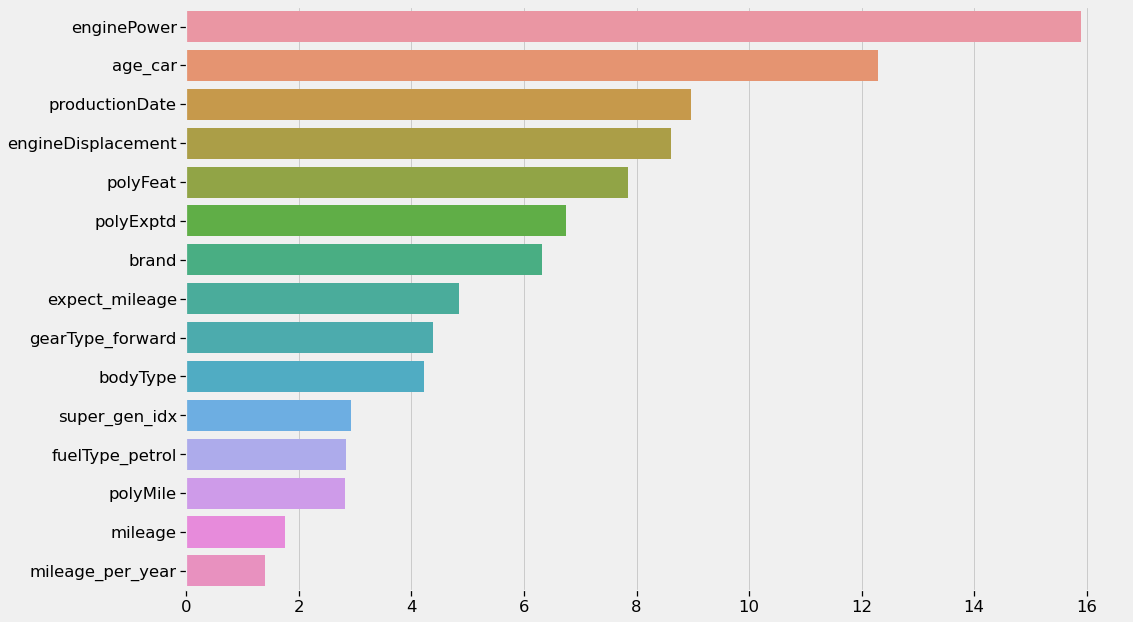

In [169]:
# какие признаки оказывают максимальное влияние
idx = np.flip(np.argsort(model2.feature_importances_))
sns.barplot(x=model2.feature_importances_[idx[:15]], y=np.array(model2.feature_names_)[idx[:15]])

## Поиск наилучших параметров для CatBoostRegressor

In [170]:
# Поиск наилучших параметров для CatBoostRegressor
# cbr = CatBoostRegressor()

# grid = {'learning_rate': [round(x,3) for x in np.linspace(start = 0.025, stop = 0.4, num = 40)],
#         'depth': [int(x) for x in np.linspace(start = 5, stop = 10, num = 5)],
#         'l2_leaf_reg': [int(x) for x in np.linspace(start = 1, stop = 5, num = 5)]}

# grid_search_result = cbr.grid_search(grid, 
#                                       X=X_train, 
#                                       y=y_train, 
#                                       plot=False)
# print(grid_search_result['params'])


**'depth': 5, 'l2_leaf_reg': 1, 'learning_rate': 0.121**

## Model 3 : CatBoost (best params)

In [171]:
model3 = CatBoostRegressor(iterations = 4000,
                              learning_rate = 0.121,
                              l2_leaf_reg = 1,
                              depth=5,
                              od_type='Iter',
                              od_wait=500,
                              bootstrap_type = 'Bayesian',
                              bagging_temperature = 0.1,
                              eval_metric='MAPE',
                              random_seed = RANDOM_SEED,)
model3.fit(X_train, y_train,
        # cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=500,
         use_best_model=True,
         plot=True)



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0516204	test: 0.0520211	best: 0.0520211 (0)	total: 27.9ms	remaining: 1m 51s
500:	learn: 0.0102534	test: 0.0112784	best: 0.0112784 (500)	total: 3.57s	remaining: 24.9s
1000:	learn: 0.0091355	test: 0.0108429	best: 0.0108425 (999)	total: 7.19s	remaining: 21.5s
1500:	learn: 0.0084492	test: 0.0106858	best: 0.0106858 (1500)	total: 10.6s	remaining: 17.7s
2000:	learn: 0.0079114	test: 0.0106160	best: 0.0106082 (1949)	total: 15.1s	remaining: 15s
2500:	learn: 0.0074845	test: 0.0105947	best: 0.0105931 (2470)	total: 18.9s	remaining: 11.3s
3000:	learn: 0.0071134	test: 0.0105928	best: 0.0105873 (2969)	total: 24.4s	remaining: 8.14s
3500:	learn: 0.0067928	test: 0.0105887	best: 0.0105863 (3327)	total: 29.3s	remaining: 4.18s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.01058632198
bestIteration = 3327

Shrink model to first 3328 iterations.


In [172]:
predict_best = np.round((np.exp(model3.predict(X_test)))/1000) *1000
y_test_exp = np.exp(y_test)

# оцениваем точность
print(f"Точность модели по метрике MAPE: {(mape(y_test_exp, predict_best))*100:0.2f}%")

Точность модели по метрике MAPE: 14.56%


In [173]:
model3.save_model('catboost_single_model_best_params.model')

## Model 4: GradientBoostingRegressor

In [174]:
model4 = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=15, n_estimators=1000)

model4.fit(X_train, y_train,)


GradientBoostingRegressor(learning_rate=0.03, max_depth=15, n_estimators=1000)

In [175]:
predict_gbr = np.round((np.exp(model4.predict(X_test)))/1000) *1000
y_test_exp = np.exp(y_test)

# оцениваем точность
print(f"Точность модели по метрике MAPE: {(mape(y_test_exp, predict_gbr))*100:0.2f}%")

Точность модели по метрике MAPE: 16.29%
